# Trabalho Final da Disciplina Organização do Conhecimento (MAI715)


## Análise em datasets de nanopublicações quanto à qualidade dos dados de direitos autorais e licenciamento

Programa de Pós-graduação em Informática

Universidade Federal do Rio de Janeiro (UFRJ) - Rio de Janeiro, RJ - Brasil

Trabalho da disciplina: Organização do Conhecimento (MAI715)

Professora: Giseli Rabello Lopes [giseli@dcc.ufrj.br ]

Aluno: Massao Oliveira Iwanaga [massaoiwanaga@ufrj.br]

<h2>Preâmbulo</h2>

Para rodar as análises a seguir, você precisa instalar e disponibilizar os endpoints SPARQL usando alguma triple store (Graph DB, Virtuoso, Jena Fuseki) e carregando os datasets. Em seguida é preciso atualizar os links dos endpoints na seção apropriada aqui contida.

<h3>Links com os Datasets de Nanopublicações Usados</h3>

- [neXtProt 1900_2000](https://sourceforge.net/projects/nextprot2rdf/files/data/nextprot/releases/2014-09/nextprot_19001_20000.tar.gz/download)

- [DisGetNET 4.0](http://rdf.disgenet.org/download/v4.0.0/nanopublications_v4.0.0.0.trig.gz)

- [WikiPathways 20201210](https://github.com/peta-pico/wikipathways-nanopubs/blob/master/output/combined/20201210_full.trig.gz)

- [LIDDI V1.01](https://ckannet-storage.commondatastorage.googleapis.com/2015-07-20T06:50:47.760Z/liddi-v1-01-trig.gz)

- [OpenBell Large Corpus 1.0](https://github.com/tkuhn/bel2nanopub/releases/download/v1.0/bel-corpora-output.zip)

É importante ressaltar que, por limitação da capacidade de processamento do computador pessoal e de armazenamento da versão grátis do Graph DB, os datasets foram recortados, da seguinte forma:

- [neXtProt 1900_2000]: Originalmente: 220.916 nanopublicações. Recorte deste experimento: mantendo as 68.746 primeiras nanopublicações.

- [DisGetNET 4.0]: Originalmente: 1.414.902 nanopublicações. Recorte deste experimento: mantendo as 8.235 primeiras nanopublicações.

- [WikiPathways 20201210]: Mantido com a quantidade original de nanopublicações (16.247).

- [LIDDI V1.01]: Recorte deste experimento: mantendo as 88.087 primeiras nanopublicações.

- [OpenBell Large Corpus 1.0]: Recorte deste experimento: mantendo as 48.674 primeiras nanopublicações.

## 1) Importação de Bibliotecas ##

In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import csv
from SPARQLWrapper import SPARQLWrapper, JSON, CSV, XML
import statistics
import numpy as np
from xml.dom.minidom import parse, parseString

## 2) Configurando os Endpoints SPARQL ##

In [ ]:
#Definindo o endpoint SPARQL DisGeNet e a função que executará as queries
dbSparqlDGN = SPARQLWrapper("http://DESKTOP-J4GEQRH:7200/repositories/disgenet")
dbSparqlDGN.setReturnFormat(JSON)

def queryDisGeNET(query):
    dbSparqlDGN.setQuery(query)
    results = dbSparqlDGN.queryAndConvert()
    return results

#Definindo o endpoint SPARQL NeXtProt e a função que executará as queries
dbSparqlNxt = SPARQLWrapper("http://DESKTOP-J4GEQRH:7200/repositories/nextprot")
dbSparqlNxt.setReturnFormat(JSON)

def queryNeXtProt(query):
    dbSparqlNxt.setQuery(query)
    results = dbSparqlNxt.queryAndConvert()
    return results

#Definindo o endpoint SPARQL WikiPathways e a função que executará as queries
dbSparqlWP = SPARQLWrapper("http://DESKTOP-J4GEQRH:7200/repositories/wikipathways")
dbSparqlWP.setReturnFormat(JSON)

def queryWP(query):
    dbSparqlWP.setQuery(query)
    results = dbSparqlWP.queryAndConvert()
    return results

#Definindo o endpoint SPARQL OpenBell e a função que executará as queries
dbSparqlOBL = SPARQLWrapper("http://DESKTOP-J4GEQRH:7200/repositories/belcorpora")
dbSparqlOBL.setReturnFormat(JSON)

def queryOpenBellLarge(query):
    dbSparqlOBL.setQuery(query)
    results = dbSparqlOBL.queryAndConvert()
    return results

#Definindo o endpoint SPARQL LIDDI e a função que executará as queries
dbSparqlLIDDI = SPARQLWrapper("http://DESKTOP-J4GEQRH:7200/repositories/LIDDI")
dbSparqlLIDDI.setReturnFormat(JSON)

def queryLIDDI(query):
    dbSparqlLIDDI.setQuery(query)
    results = dbSparqlLIDDI.queryAndConvert()
    return results

## 3) Definição de funções auxiliares para trabalhar com as queries

In [12]:
#Definindo a função para receber o array com o resultado da contagem (count)
def get_array(results):
    """
    Extract the count result from the JSON format
    """
    array = []
    for result in results["results"]["bindings"]:
        if((result["count"]["value"]).isnumeric()):
            value = int(result["count"]["value"])
            array.append(value)
    array.sort()
    return array

#Definindo a função para receber o array com o resultado de "rights"
def get_array2(results):
    """
    Extract the count result from the JSON format
    """
    array = []
    for result in results["results"]["bindings"]:
        if((result["count"]["value"]).isnumeric()):
            value = int(result["count"]["value"])
            array.append([result["rights"]["value"], value])
    array.sort()
    return array

#Definindo a função para receber o array com o resultado de "rights", agrupando e contando
def get_array3(results):
    """
    Extract the count result from the JSON format
    """
    array = []
    array2 = []
    for result in results["results"]["bindings"]:
        array2.append(result["rights"]["value"])
    array.append(array2)
    array2 = []
    for result in results["results"]["bindings"]:
        if((result["count"]["value"]).isnumeric()):
            value = int(result["count"]["value"])
            array2.append(value)
    array.append(array2)
    return array

#Definindo a função para receber o array com o resultado de "licence", agrupando e contando
def get_array4(results):
    """
    Extract the count result from the JSON format
    """
    array = []
    array2 = []
    for result in results["results"]["bindings"]:
        array2.append(result["licence"]["value"])
    array.append(array2)
    array2 = []
    for result in results["results"]["bindings"]:
        if((result["count"]["value"]).isnumeric()):
            value = int(result["count"]["value"])
            array2.append(value)
    array.append(array2)
    #array.sort()
    return array

#Definindo a função para receber o array com o resultado de "rightsHolder", agrupando e contando
def get_array5(results):
    """
    Extract the count result from the JSON format
    """
    array = []
    array2 = []
    for result in results["results"]["bindings"]:
        array2.append(result["rightsHolder"]["value"])
    array.append(array2)
    array2 = []
    for result in results["results"]["bindings"]:
        if((result["count"]["value"]).isnumeric()):
            value = int(result["count"]["value"])
            array2.append(value)
    array.append(array2)
    #array.sort()
    return array

def average(list):
    return sum(list) / float(len(list)) 

## Análise do NeXtProt ##

### [NeXtProt](https://www.nextprot.org/) ###

neXtProt é uma plataforma de conhecimento on-line sobre proteínas humanas. Ele se dedica a ser um recurso abrangente que fornece uma variedade de tipos de informações sobre proteínas humanas, como sua função, localização subcelular, expressão, interações e papel nas doenças.

In [13]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo HEAD em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(?h) as ?count) 
where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
                  ?p ?o .
       }
    }
GROUP BY ?h
"""

results = queryNeXtProt(query)
nxtHeadTriples = get_array(results)
#print(nxtHeadTriples)

URLError: <urlopen error [WinError 10061] Nenhuma conexão pôde ser feita porque a máquina de destino as recusou ativamente>

In [ ]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo ASSERTION em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>
    select (count(*) as ?count)
    where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasAssertion ?a .
      }
      graph ?a {?s ?p ?o}
    } 
    GROUP BY ?a
"""

results = queryNeXtProt(query)
nxtAssertionTriples = get_array(results)
#print(nxtAssertionTriples)

In [14]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PUBLICATION INFO em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>
    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasPublicationInfo ?pubInfo .
      }
      graph ?pubInfo {?s ?p ?o}
    } 
    GROUP BY ?pubInfo
"""

results = queryNeXtProt(query)
nxtPubInfoTriples = get_array(results)
#print(nxtPubInfoTriples)

URLError: <urlopen error [WinError 10061] Nenhuma conexão pôde ser feita porque a máquina de destino as recusou ativamente>

In [ ]:
# Armazenando o resultado em um arquivo CSV:
with open('distributionNeXtProt.csv', mode='w') as csv_file:
    fieldnames = ['Grafos', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['Grafos', 'Triplas'])
    
    # Grafos HEAD
    for t in nxtHeadTriples:
        writer.writerow(['Head', t])
    
    # Grafos ASSERTION
    for t in nxtAssertionTriples:
        writer.writerow(['Assertion', t])
        
    # Grafos PROVENANCE
    for t in nxtProvenanceTriples:
        writer.writerow(['Provenance', t])
        
    # Grafos PUBLICATION INFO
    for t in nxtPubInfoTriples:
        writer.writerow(['PublicationInfo', t])

In [ ]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PROVENANCE em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasProvenance ?prov .
      }
      graph ?prov {?s ?p ?o}
    } 
    GROUP BY ?prov
"""

results = queryNeXtProt(query)
nxtProvenanceTriples = get_array(results)
#print(nxtProvenanceTriples)

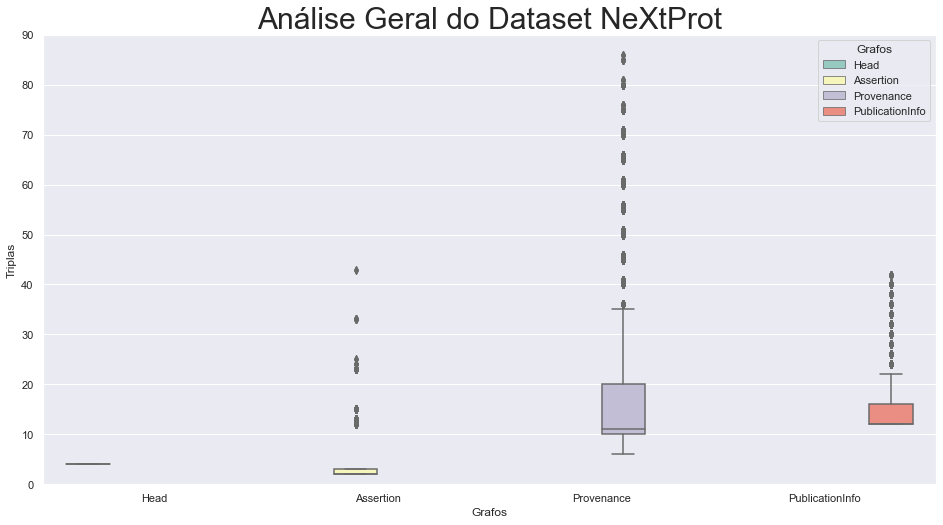

In [15]:
dataNeXt = pd.read_csv('distributionNeXtProt.csv')

sns.set(style="whitegrid"),
sns.set(rc={'figure.figsize':(16,8.27)}),
ax = sns.boxplot(x="Grafos", y="Triplas", hue="Grafos", data=dataNeXt, palette="Set3")
ax.axes.set_title("Análise Geral do Dataset NeXtProt",fontsize=30)
ax.set_ylim(0, 90);

In [18]:
# Contagem de nanopublicações usando dcterms:rights no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
"""

results = queryNeXtProt(query)
nxtNumRights = get_array(results)
print(nxtNumRights)

[68746]


In [21]:
# Lista os diferentes objetos do predicado dcterms:rights no Publication Info e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dcterms:rights
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rights (count(?rights) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
GROUP BY ?rights
"""

results = queryNeXtProt(query)
nxtRightsCont = get_array3(results)
print(nxtRightsCont)
#print(results)
#nxtRightsCont_matriz = np.asmatrix(nxtRightsCont)

[['http://creativecommons.org/licenses/by/3.0/'], [68746]]


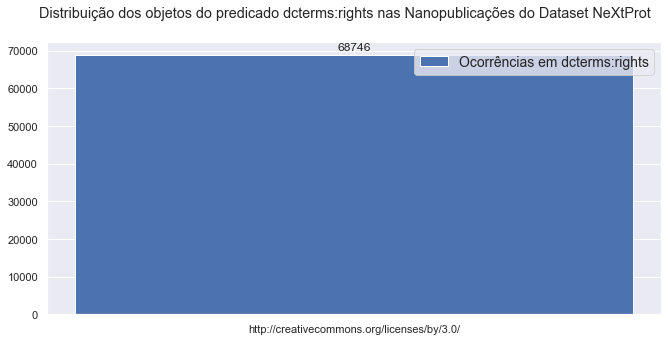

In [22]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
#plt.bar(nxtRightsCont[0], nxtRightsCont[1], label = 'Ocorrências do objeto')
rect = ax.bar(nxtRightsCont[0], nxtRightsCont[1], label = 'Ocorrências em dcterms:rights')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rights nas Nanopublicações do Dataset NeXtProt");
plt.show()

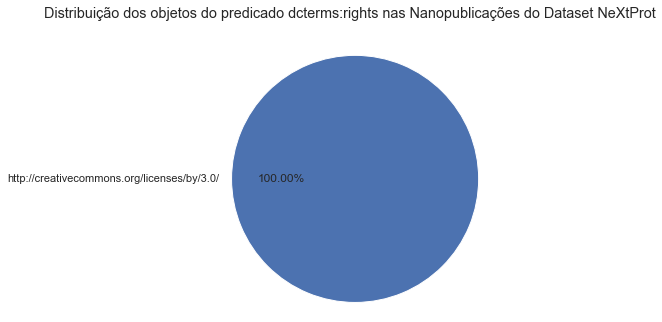

In [23]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(nxtRightsCont[1], labels=nxtRightsCont[0], autopct='%1.2f%%')
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dcterms:rights nas Nanopublicações do Dataset NeXtProt");

In [24]:
# Contagem de nanopublicações usando dcterms:rightsHolder no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
"""

results = queryNeXtProt(query)
nxtNumRightsHolder = get_array(results)
print(nxtNumRightsHolder)

[68746]


In [25]:
# Lista os diferentes objetos do predicado dcterms:rightsHolder no Publication Info e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dcterms:rightsHolder
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rightsHolder (count(?rightsHolder) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
GROUP BY ?rightsHolder
"""

results = queryNeXtProt(query)
nxtRightsHolderCont = get_array5(results)
print(nxtRightsHolderCont)

[['http://nextprot.org'], [68746]]


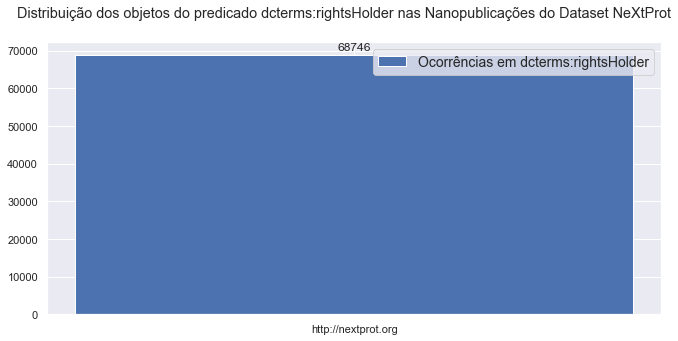

In [26]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(nxtRightsHolderCont[0], nxtRightsHolderCont[1], label = 'Ocorrências em dcterms:rightsHolder')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset NeXtProt");
plt.show()

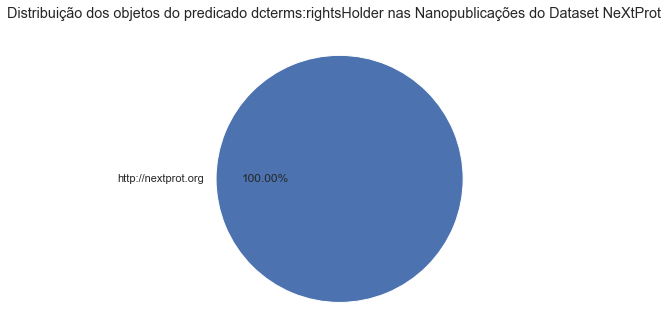

In [27]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(nxtRightsHolderCont[1], labels=nxtRightsHolderCont[0], autopct='%1.2f%%')
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset NeXtProt");

In [28]:
# Contagem de nanopublicações usando dcterms:licence no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
"""

results = queryNeXtProt(query)
nxtNumLicence = get_array(results)
print(nxtNumLicence)

[0]


In [29]:
# Lista os diferentes objetos do predicado dcterms:licence no Publication Info e conta quantas ocorrências há
# Não foram retornados valores
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?licence (count(?licence) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
GROUP BY ?licence
"""

results = queryNeXtProt(query)
nxtLicenceCont = get_array4(results)
print(nxtLicenceCont)

[[], []]


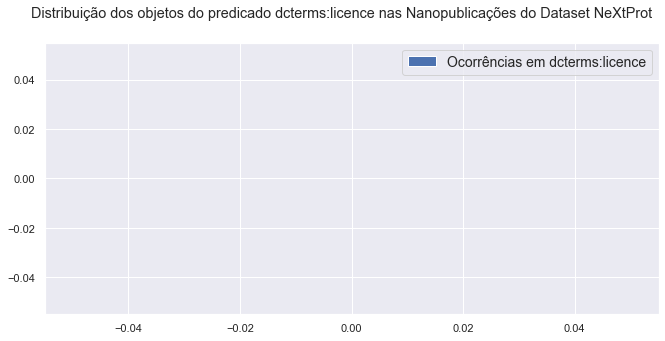

In [30]:
#Zero ocorrência
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(nxtLicenceCont[0], nxtLicenceCont[1], label = 'Ocorrências em dcterms:licence')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset NeXtProt");
plt.show()

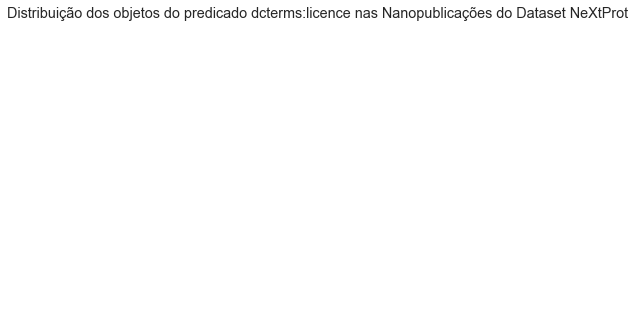

In [31]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(nxtLicenceCont[1], labels=nxtLicenceCont[0], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset NeXtProt");
plt.show()

## Análise do WikiPathways ##

### [WikiPathways](https://www.wikipathways.org)

O WikiPathways foi estabelecido para facilitar a contribuição e manutenção de informações sobre caminhos pela comunidade biológica. WikiPathways é uma plataforma aberta e colaborativa dedicada à curadoria de vias biológicas. Cada caminho no WikiPathways tem uma página wiki dedicada, exibindo o diagrama atual, descrição, referências, opções de download, histórico de versões e listas de genes e proteínas de componentes. Qualquer caminho pode ser editado a partir de sua página wiki ativando um editor de caminho embutido.

[Portal da Web Semântica WikiPathways] (https://www.wikipathways.org/index.php/Portal:Semantic_Web) descreve os recursos da Web Semântica dos bancos de dados WikiPathways, como a tradução Resource Description Framework (RDF), a ontologia e as novas nanopublicações.

Está em uso no experimento a versão 2017 da nanopublicação da Wikipathways. O autor Tobias Kuhn converteu o banco de dados de wikipathways em nanopublicação em 5 de outubro de 2017.

In [32]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo HEAD em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(?h) as ?count)
where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
                  ?p ?o .
       }
    }
GROUP BY ?h
"""

results = queryWP(query)
wpHeadTriples = get_array(results)

In [33]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo ASSERTION em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count)
    where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasAssertion ?a .
      }
      graph ?a {?s ?p ?o}
    } 
    GROUP BY ?a
"""

results = queryWP(query)
wpAssertionTriples = get_array(results)

In [34]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PROVENANCE em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count)
    where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasProvenance ?prov .
      }
      graph ?prov {?s ?p ?o}
    } 
    GROUP BY ?prov
"""

results = queryWP(query)
wpProvenanceTriples = get_array(results)

In [35]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PUBLICATION INFO em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count)
    where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasPublicationInfo ?pubInfo .
      }
      graph ?pubInfo {?s ?p ?o}
    } 
    GROUP BY ?pubInfo
"""

results = queryWP(query)
wpPubInfoTriples = get_array(results)

In [36]:
with open('distributionWikiPathways.csv', mode='w') as csv_file:
    fieldnames = ['Grafos', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['Grafos', 'Triplas'])
    
    # For Head Graph
    for t in wpHeadTriples:
        writer.writerow(['Head', t])
    
    #For Assertion Graph
    for t in wpAssertionTriples:
        writer.writerow(['Assertion', t])
        
    #For Provenance Graph
    for t in wpProvenanceTriples:
        writer.writerow(['Provenance', t])
        
    #For Publication Information Graph
    for t in wpPubInfoTriples:
        writer.writerow(['PublicationInfo', t])

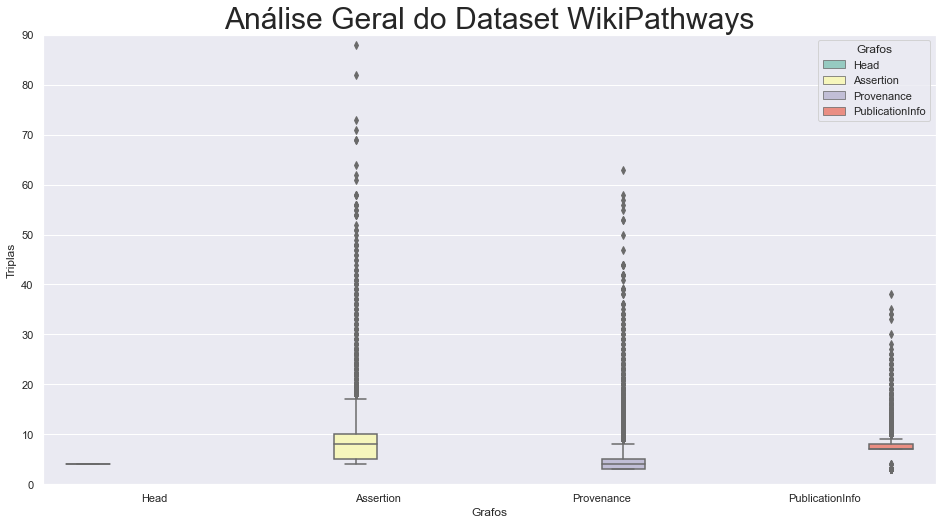

In [37]:
dataWP = pd.read_csv('distributionWikiPathways.csv')

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="Grafos", y="Triplas", hue="Grafos", data=dataWP, palette="Set3")
ax.axes.set_title("Análise Geral do Dataset WikiPathways",fontsize=30)

#the y-axis is cut-off at a count of 90. The WikiPathways nanopublications include up to 1,001 triples in the assertion graph.
ax.set_ylim(0, 90);

In [38]:
# Contagem de nanopublicações usando dcterms:rights no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
"""

results = queryWP(query)
wpNumRights = get_array(results)
print(wpNumRights)

[16247]


In [39]:
# Lista os diferentes objetos do predicado dcterms:rights no Publication Info e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dcterms:rights
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rights (count(?rights) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
GROUP BY ?rights
"""

results = queryWP(query)
wpRightsCont = get_array3(results)
print(wpRightsCont)

[['http://creativecommons.org/publicdomain/zero/1.0/'], [16247]]


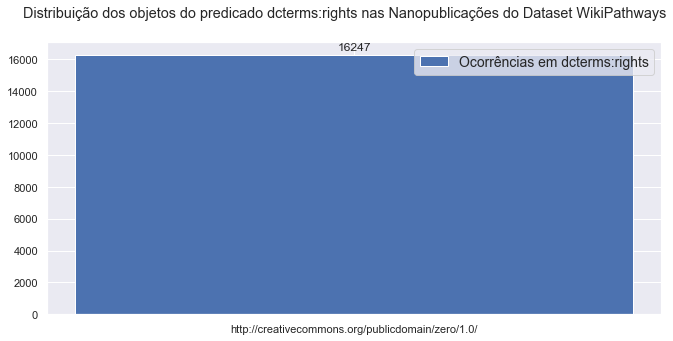

In [40]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(wpRightsCont[0], wpRightsCont[1], label = 'Ocorrências em dcterms:rights')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rights nas Nanopublicações do Dataset WikiPathways");
plt.show()

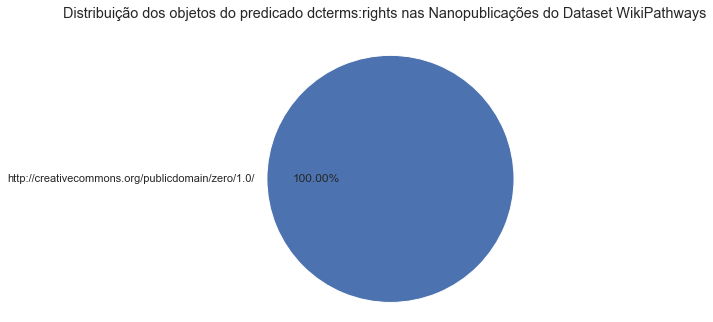

In [41]:
#plt.pie(wpRightsCont[0], wpRightsCont[1])
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(wpRightsCont[1], labels=wpRightsCont[0], autopct='%1.2f%%')
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dcterms:rights nas Nanopublicações do Dataset WikiPathways");

In [42]:
# Contagem de nanopublicações usando dcterms:rightsHolder no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
"""

results = queryWP(query)
wpNumRightsHolder = get_array(results)
print(wpNumRightsHolder)

[0]


In [43]:
# Lista os diferentes objetos do predicado dcterms:rightsHolder no Publication Info e conta quantas ocorrências há
# Nenhum resultado encontrado
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rightsHolder (count(?rightsHolder) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
GROUP BY ?rightsHolder
"""

results = queryWP(query)
wpRightsHolderCont = get_array5(results)
print(wpRightsHolderCont)

[[], []]


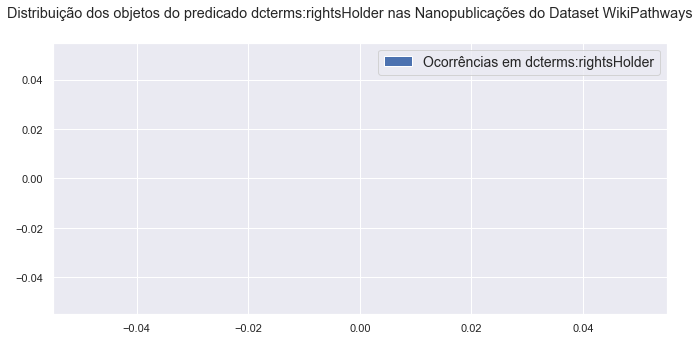

In [44]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(wpRightsHolderCont[0], wpRightsHolderCont[1], label = 'Ocorrências em dcterms:rightsHolder')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset WikiPathways");
plt.show()

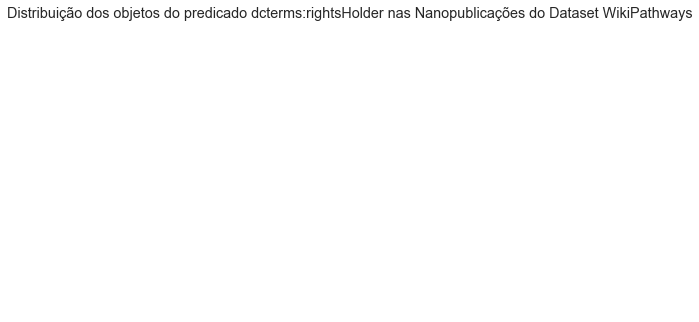

In [45]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(wpRightsHolderCont[1], labels=wpRightsHolderCont[0], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset WikiPathways");

In [46]:
# Contagem de nanopublicações usando dcterms:licence no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:licence) ?licence .
  }
}
"""

results = queryWP(query)
wpNumLicence = get_array(results)
print(wpNumLicence)

[0]


In [47]:
# Lista os diferentes objetos do predicado dcterms:licence no Publication Info e conta quantas ocorrências há
# Não foram retornados valores
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?licence (count(?licence) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
GROUP BY ?licence
"""

results = queryWP(query)
wpLicenceCont = get_array4(results)
print(wpLicenceCont)

[[], []]


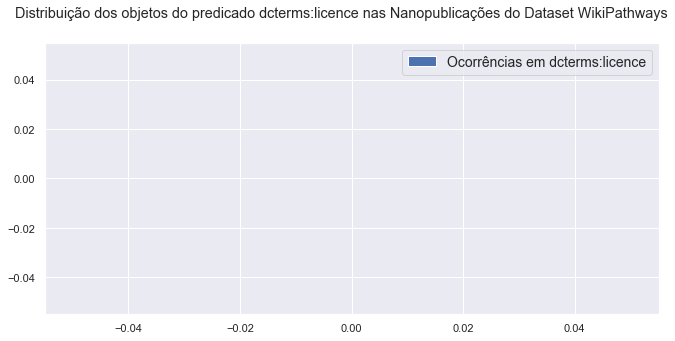

In [48]:
#Zero ocorrência
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(nxtLicenceCont[0], nxtLicenceCont[1], label = 'Ocorrências em dcterms:licence')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset WikiPathways");
plt.show()

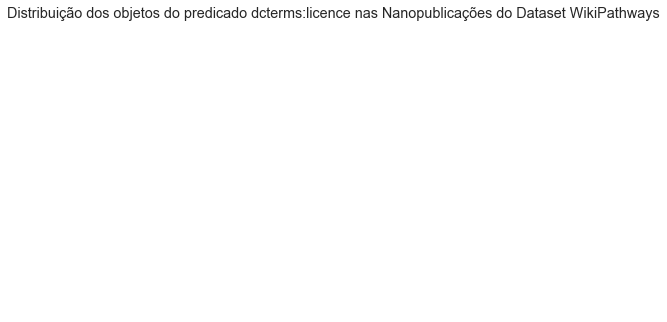

In [49]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(nxtLicenceCont[1], labels=nxtLicenceCont[0], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset WikiPathways");
plt.show()

## Análise do DisGeNET ##

### [DisGeNet](http://www.disgenet.org/) ###

DisGeNET é uma plataforma de descoberta contendo uma das maiores coleções publicamente disponíveis de genes e variantes associadas a doenças humanas. DisGeNET integra dados de repositórios com curadoria de especialistas, catálogos GWAS, modelos animais e literatura científica. Os dados do DisGeNET são anotados de maneira homogênea com vocabulários controlados e ontologias baseadas na comunidade. Além disso, várias métricas originais são fornecidas para auxiliar na priorização das relações genótipo-fenótipo.

Estamos usando um recorte da versão DisGeNET 4.0.

In [51]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo HEAD em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

select (count(*) as ?count)
where {
  {
    graph ?G {?h a np:Nanopublication .
              }
   } 
  graph ?G {?S ?P ?O}
} 
group by ?G
"""

results = queryDisGeNET(query)
dgHeadTriples = get_array(results)

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

In [64]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo ASSERTION em cada nanopublicação
query = """
    prefix np: <http://www.nanopub.org/nschema#>

        select (count(*) as ?count) where {
          graph ?h {
            ?_np_iri a np:Nanopublication ;
              np:hasAssertion ?a .
          }
          graph ?a {?s ?p ?o}
        } 
        GROUP BY ?a
    """

results = queryDisGeNET(query)
dgAssertionTriples = get_array(results)

In [53]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PROVENANCE em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasProvenance ?prov .
      }
      graph ?prov {?s ?p ?o}
    } 
    GROUP BY ?prov
"""

results = queryDisGeNET(query)
dgProvenanceTriples = get_array(results)

In [66]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PUBLICATION INFO em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasPublicationInfo ?pubInfo .
      }
      graph ?pubInfo {?s ?p ?o}
    } 
    GROUP BY ?pubInfo
"""

results = queryDisGeNET(query)
dgPubInfoTriples = get_array(results)

In [61]:
with open('distributionDisGeNET.csv', mode='w') as csv_file:
    fieldnames = ['Grafos', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['Grafos', 'Triplas'])
    
    # For Head Graph
    for t in dgHeadTriples:
        writer.writerow(['Head', t])
    
    #For Assertion Graph
    for t in dgAssertionTriples:
        writer.writerow(['Assertion', t])
        
    #For Provenance Graph
    for t in dgProvenanceTriples:
        writer.writerow(['Provenance', t])
        
    #For Publication Information Graph
    for t in dgPubInfoTriples:
        writer.writerow(['PublicationInfo', t])

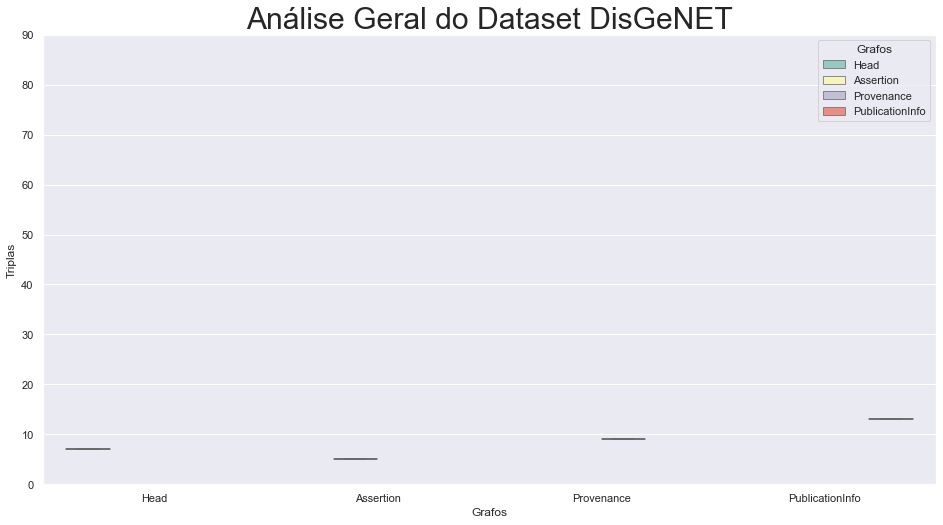

In [62]:
#Run this script if you have not installed virtuoso and jena fuseki
dataDG = pd.read_csv('distributionDisGeNET.csv')

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="Grafos", y="Triplas", hue="Grafos", data=dataDG, palette="Set3")
ax.axes.set_title("Análise Geral do Dataset DisGeNET",fontsize=30)
ax.set_ylim(0, 90);

In [67]:
# Contagem de nanopublicações usando dcterms:rights no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
"""

results = queryDisGeNET(query)
dgNumRights = get_array(results)
print(dgNumRights)

[8235]


In [68]:
# Lista os diferentes objetos do predicado dcterms:rights no Publication Info e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dcterms:rights
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rights (count(?rights) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
GROUP BY ?rights
"""

results = queryDisGeNET(query)
dgRightsCont = get_array3(results)
print(dgRightsCont)

[['http://opendatacommons.org/licenses/odbl/1.0/'], [8235]]


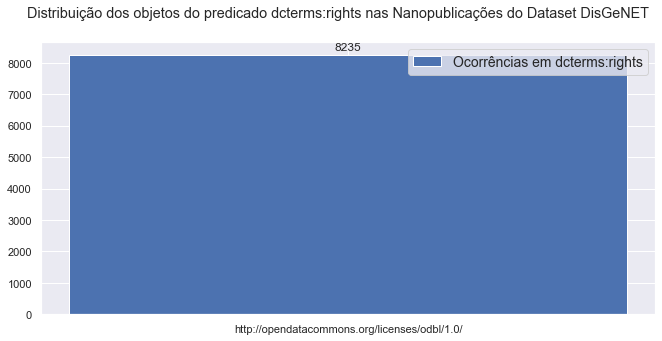

In [70]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(dgRightsCont[0], dgRightsCont[1], label = 'Ocorrências em dcterms:rights')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rights nas Nanopublicações do Dataset DisGeNET");
plt.show()

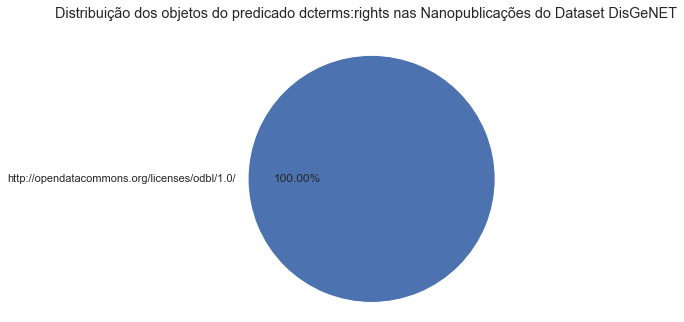

In [71]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(dgRightsCont[1], labels=dgRightsCont[0], autopct='%1.2f%%')
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dcterms:rights nas Nanopublicações do Dataset DisGeNET");

In [72]:
# Contagem de nanopublicações usando dcterms:rightsHolder no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
"""

results = queryDisGeNET(query)
dgNumRightsHolder = get_array(results)
print(dgNumRightsHolder)

[8235]


In [74]:
# Lista os diferentes objetos do predicado dcterms:rightsHolder no Publication Info e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dcterms:rightsHolder
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rightsHolder (count(?rightsHolder) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
GROUP BY ?rightsHolder
"""

results = queryDisGeNET(query)
dgRightsHolderCont = get_array5(results)
print(dgRightsHolderCont)

[['http://rdf.disgenet.org/v4.0.0/void/IBIGroup'], [8235]]


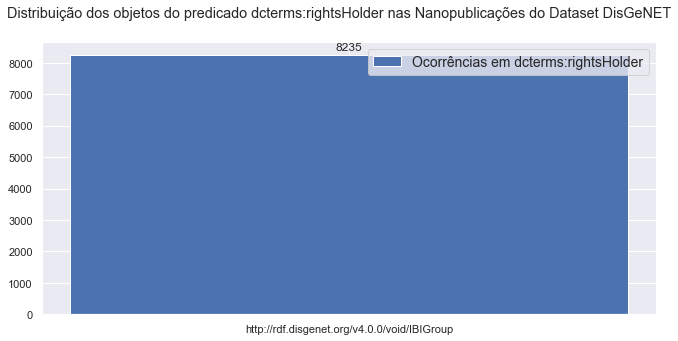

In [75]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(dgRightsHolderCont[0], dgRightsHolderCont[1], label = 'Ocorrências em dcterms:rightsHolder')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset DisGeNET");
plt.show()

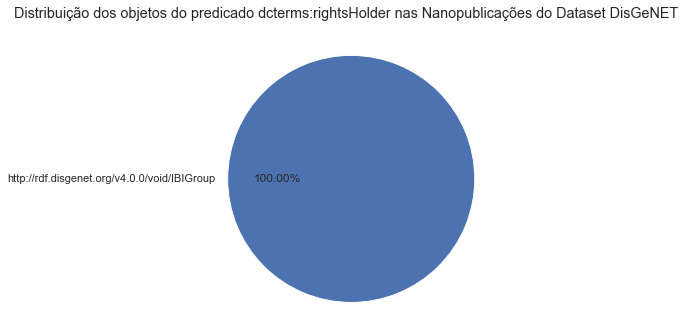

In [76]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(dgRightsHolderCont[1], labels=dgRightsHolderCont[0], autopct='%1.2f%%')
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset DisGeNET");

In [111]:
# Contagem de nanopublicações usando dcterms:licence no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
"""

results = queryDisGeNET(query)
dgNumLicence = get_array(results)
print(dgNumLicence)

[0]


In [112]:
# Lista os diferentes objetos do predicado dcterms:licence no Publication Info e conta quantas ocorrências há
# Nenhum resultado encontrado
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?licence (count(?licence) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
GROUP BY ?licence
"""

results = queryDisGeNET(query)
dgLicenceCont = get_array4(results)
print(dgLicenceCont)

[[], []]


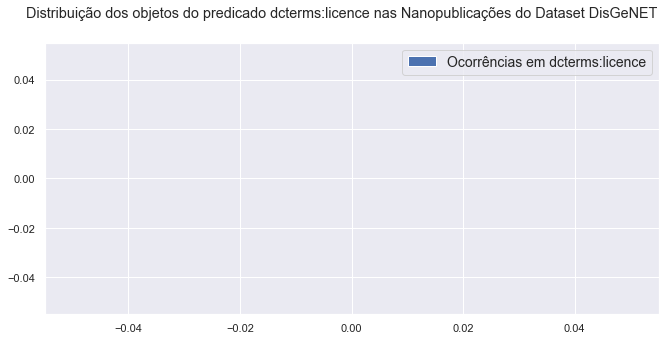

In [79]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(dgLicenceCont[0], dgLicenceCont[1], label = 'Ocorrências em dcterms:licence')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset DisGeNET");
plt.show()

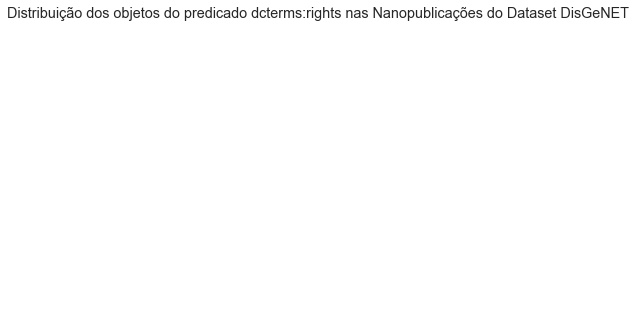

In [81]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(dgLicenceCont[1], labels=dgLicenceCont[0], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dcterms:rights nas Nanopublicações do Dataset DisGeNET");

## Análise do OpenBel Large Corpus

### [OpenBEL](http://openbel.org/) ###

A linguagem de expressão biológica (BEL) é uma linguagem para representar descobertas científicas nas ciências da vida de uma forma computável. BEL é projetado para representar descobertas científicas capturando relações causais e correlativas no contexto, onde o contexto pode incluir informações sobre o sistema biológico e experimental no qual as relações foram observadas, as publicações de apoio citadas e o processo de curadoria usado.


##### Large Corpus #####
Este corpus não inclui declarações extraídas de tabelas ou experimentos de alto rendimento, e as citações correspondentes não foram necessariamente com curadoria completa como no pequeno corpus. As declarações são uma coleção de observações independentes que não foram selecionadas para representar qualquer processo biológico específico ou via (s) de sinalização. As declarações de controle da transcrição foram selecionadas de maneira equilibrada e as cascatas de sinalização de proteínas foram incluídas em detalhes razoáveis. 

In [90]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo HEAD em cada nanopublicação
query = """
   prefix np: <http://www.nanopub.org/nschema#>
select (count(?h) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
                  ?p ?o .
       }
    }
GROUP BY ?h
    """

results = queryOpenBellLarge(query)
openBellHeadTriples = get_array(results)

In [92]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo ASSERTION em cada nanopublicação
query = """
    prefix np: <http://www.nanopub.org/nschema#>

        select (count(*) as ?count) where {
          graph ?h {
            ?_np_iri a np:Nanopublication ;
              np:hasAssertion ?a .
          }
          graph ?a {?s ?p ?o}
        } 
        GROUP BY ?a
    """

results = queryOpenBellLarge(query)
openBellAssertionTriples = get_array(results)

In [94]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PROVENANCE em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasProvenance ?prov .
      }
      graph ?prov {?s ?p ?o}
    } 
    GROUP BY ?prov
"""

results = queryOpenBellLarge(query)
openBellProvenanceTriples = get_array(results)

In [96]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PUBLICATION INFO em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasPublicationInfo ?pubInfo .
      }
      graph ?pubInfo {?s ?p ?o}
    } 
    GROUP BY ?pubInfo
"""

results = queryOpenBellLarge(query)
openBellPubInfoTriples = get_array(results)

In [100]:
with open('distributionOpenBel.csv', mode='w') as csv_file:
    fieldnames = ['Grafos', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['Grafos', 'Triplas'])
    
    # For Head Graph
    for t in openBellHeadTriples:
        writer.writerow(['Head', t])
    
    #For Assertion Graph
    for t in openBellAssertionTriples:
        writer.writerow(['Assertion', t])
        
    #For Provenance Graph
    for t in openBellProvenanceTriples:
        writer.writerow(['Provenance', t])
        
    #For Publication Information Graph
    for t in openBellPubInfoTriples:
        writer.writerow(['PublicationInfo', t])

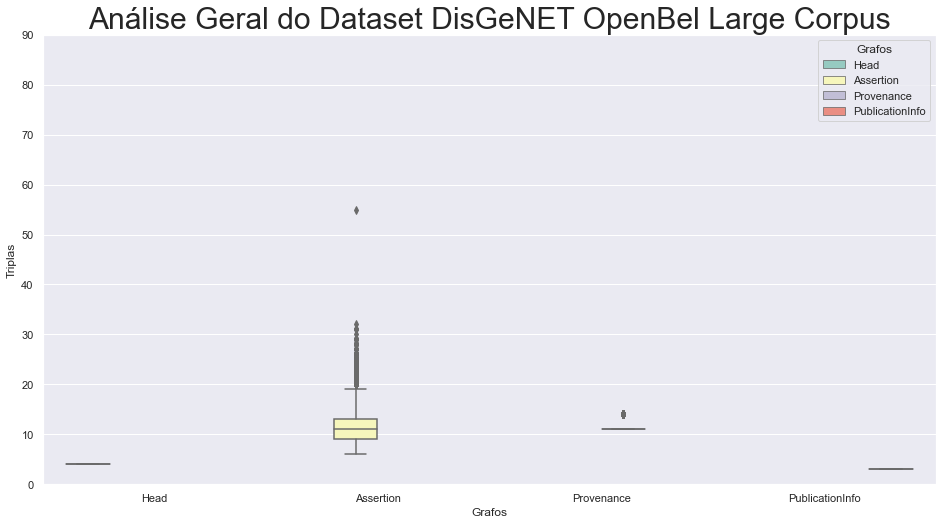

In [101]:
dataOB = pd.read_csv('distributionOpenBel.csv')

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="Grafos", y="Triplas", hue="Grafos", data=dataOB, palette="Set3")
ax.axes.set_title("Análise Geral do Dataset DisGeNET OpenBel Large Corpus",fontsize=30)
ax.set_ylim(0, 90);

In [105]:
# Contagem de nanopublicações usando dcterms:rights no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dce: <http://purl.org/dc/elements/1.1/>
select (count(?rights) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasProvenance ?provenance .
  }
  graph ?provenance {
    ?s dce:rights ?rights .
  }
}
"""

results = queryOpenBellLarge(query)
oblNumRights = get_array(results)
print(oblNumRights)

[48674]


In [106]:
# Lista os diferentes objetos do predicado dce:rights no Provenance e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dce:rights
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dce: <http://purl.org/dc/elements/1.1/>
select ?rights (count(?rights) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasProvenance ?provenance .
  }
  graph ?provenance {
    ?s dce:rights ?rights .
  }
}
GROUP BY ?rights
"""

results = queryOpenBellLarge(query)
oblRightsCont = get_array3(results)
print(oblRightsCont)

[['Copyright (c) 2011-2012, Selventa. All rights reserved.'], [48674]]


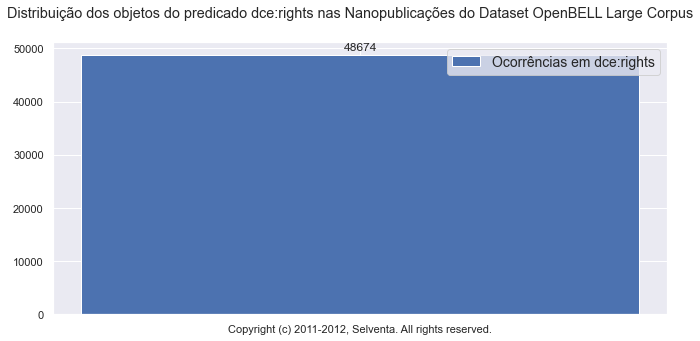

In [109]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(oblRightsCont[0], oblRightsCont[1], label = 'Ocorrências em dce:rights')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dce:rights nas Nanopublicações do Dataset OpenBELL Large Corpus");
plt.show()

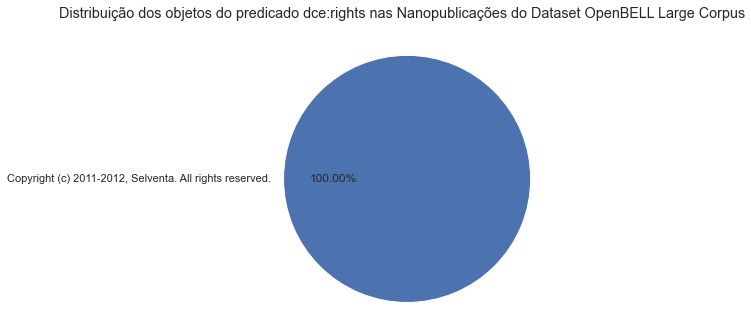

In [110]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(oblRightsCont[1], labels=oblRightsCont[0], autopct='%1.2f%%')
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dce:rights nas Nanopublicações do Dataset OpenBELL Large Corpus");

In [113]:
# Contagem de nanopublicações usando dcterms:rightsHolder no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
"""

results = queryOpenBellLarge(query)
oblNumRightsHolder = get_array(results)
print(oblNumRightsHolder)

[0]


In [114]:
# Lista os diferentes objetos do predicado dcterms:rightsHolder no Publication Info e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dcterms:rightsHolder
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rightsHolder (count(?rightsHolder) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
GROUP BY ?rightsHolder
"""

results = queryOpenBellLarge(query)
oblRightsHolderCont = get_array5(results)
print(oblRightsHolderCont)

[[], []]


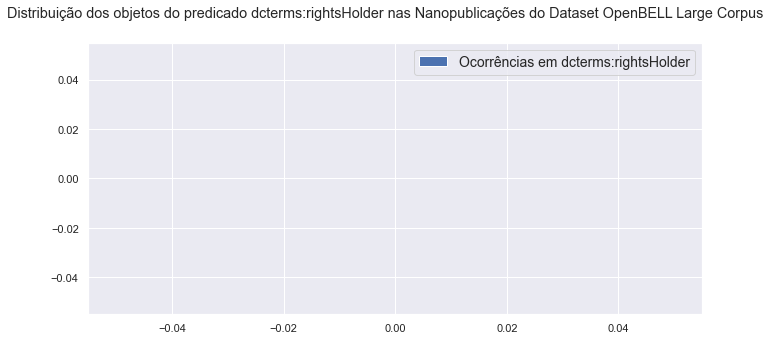

In [118]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(oblRightsHolderCont[0], oblRightsHolderCont[1], label = 'Ocorrências em dcterms:rightsHolder')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset OpenBELL Large Corpus");
plt.show()

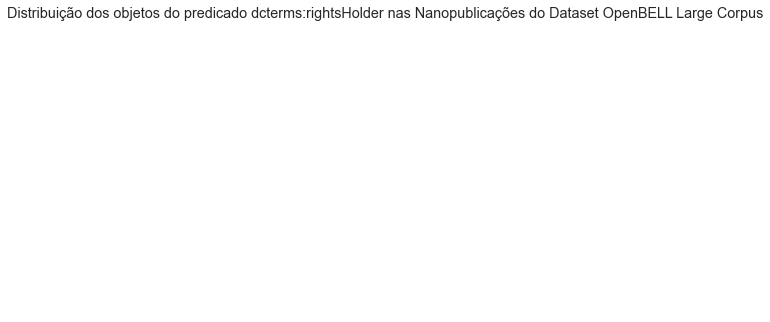

In [119]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(oblRightsHolderCont[1], labels=oblRightsHolderCont[0], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset OpenBELL Large Corpus");

In [120]:
# Contagem de nanopublicações usando dcterms:licence no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
"""

results = queryOpenBellLarge(query)
oblNumLicence = get_array(results)
print(oblNumLicence)

[0]


In [121]:
# Lista os diferentes objetos do predicado dcterms:licence no Publication Info e conta quantas ocorrências há
# Não foram retornados valores

query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?licence (count(?licence) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
GROUP BY ?licence
"""

results = queryOpenBellLarge(query)
oblLicenceCont = get_array4(results)
print(oblLicenceCont)

[[], []]


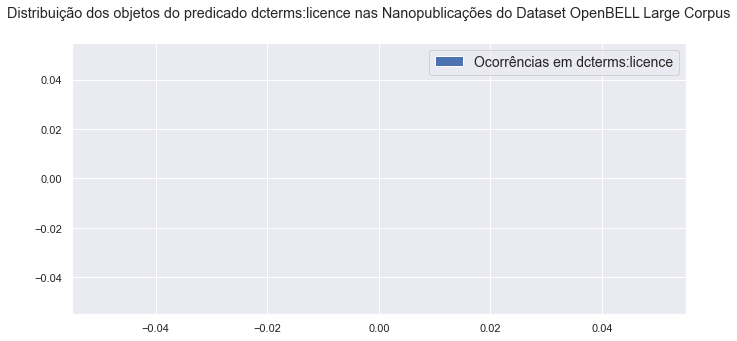

In [122]:
#Zero ocorrência
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(oblLicenceCont[0], oblLicenceCont[1], label = 'Ocorrências em dcterms:licence')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset OpenBELL Large Corpus");
plt.show()

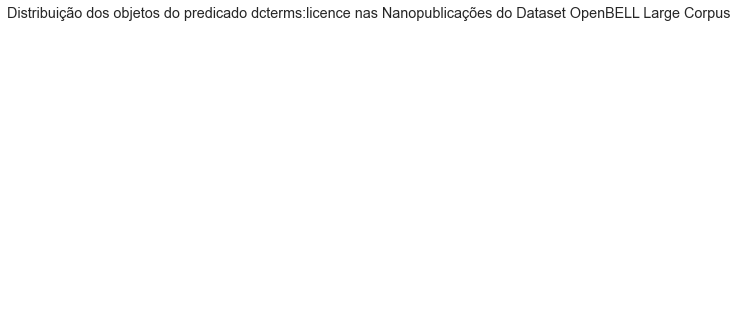

In [123]:

# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(oblLicenceCont[1], labels=oblLicenceCont[0], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset OpenBELL Large Corpus");
plt.show()

## Análise do LInked Drug-Drug Interactions (LIDDI)

### [LIDDI](https://arxiv.org/abs/1507.05408) ###

LInked Drug-Drug Interactions (LIDDI) é um conjunto de dados RDF público baseado em nanopublicação com URIs confiáveis que abrange alguns dos métodos e fontes de previsão mais citados para fornecer aos pesquisadores um recurso para alavancar o trabalho de outros em seus métodos de previsão. Como um dos principais problemas para superar o uso de recursos externos são seus mapeamentos entre nomes de medicamentos e identificadores usados, também fornecemos o conjunto de mapeamentos que organizamos para poder comparar as várias fontes que agregamos em nosso conjunto de dados.

Este conjunto de dados combina dados sobre interações medicamentosas de diferentes fontes e os formata como nanopublicações. 

In [124]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo HEAD em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(?h) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
                  ?p ?o .
       }
    }
GROUP BY ?h
"""

results = queryLIDDI(query)
liddiHeadTriples = get_array(results)

In [125]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo ASSERTION em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasAssertion ?a .
      }
      graph ?a {?s ?p ?o}
    } 
    GROUP BY ?a
"""

results = queryLIDDI(query)
liddiAssertionTriples = get_array(results)

In [126]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PROVENANCE em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasProvenance ?prov .
      }
      graph ?prov {?s ?p ?o}
    } 
    GROUP BY ?prov
"""

results = queryLIDDI(query)
liddiProvenanceTriples = get_array(results)

In [127]:
# A query SPARQL a seguir realiza a contagem de triplas de cada grafo PUBLICATION INFO em cada nanopublicação
query = """
prefix np: <http://www.nanopub.org/nschema#>

    select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication ;
          np:hasPublicationInfo ?pubInfo .
      }
      graph ?pubInfo {?s ?p ?o}
    } 
    GROUP BY ?pubInfo
"""

results = queryLIDDI(query)
liddiPubInfoTriples = get_array(results)

In [129]:
with open('distributionLIDD.csv', mode='w') as csv_file:
    fieldnames = ['Grafo', 'Triplas']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['Grafo', 'Triplas'])
    
    # For Head Graph
    for t in liddiHeadTriples:
        writer.writerow(['Head', t])
    
    #For Assertion Graph
    for t in liddiAssertionTriples:
        writer.writerow(['Assertion', t])
        
    #For Provenance Graph
    for t in liddiProvenanceTriples:
        writer.writerow(['Provenance', t])
        
    #For Publication Information Graph
    for t in liddiPubInfoTriples:
        writer.writerow(['PublicationInfo', t])

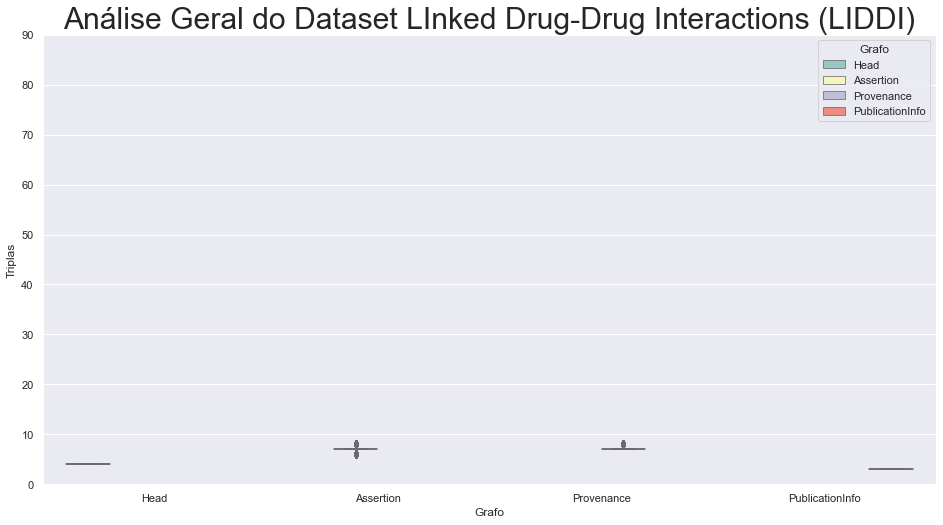

In [130]:
#Run this script if you have not installed virtuoso and jena fuseki
dataLiddi = pd.read_csv('distributionLIDD.csv')

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="Grafo", y="Triplas", hue="Grafo", data=dataLiddi, palette="Set3")
ax.axes.set_title("Análise Geral do Dataset LInked Drug-Drug Interactions (LIDDI)",fontsize=30)
ax.set_ylim(0, 90);

In [131]:
# Contagem de nanopublicações usando dcterms:rights no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
"""

results = queryLIDDI(query)
liddiNumRights = get_array(results)
print(liddiNumRights)

[0]


In [133]:
# Lista os diferentes objetos do predicado dcterms:rights no Publication Info e conta quantas ocorrências há
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rights (count(?rights) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rights) ?rights .
  }
}
GROUP BY ?rights
"""

results = queryLIDDI(query)
liddiRightsCont = get_array3(results)
print(liddiRightsCont)

[[], []]


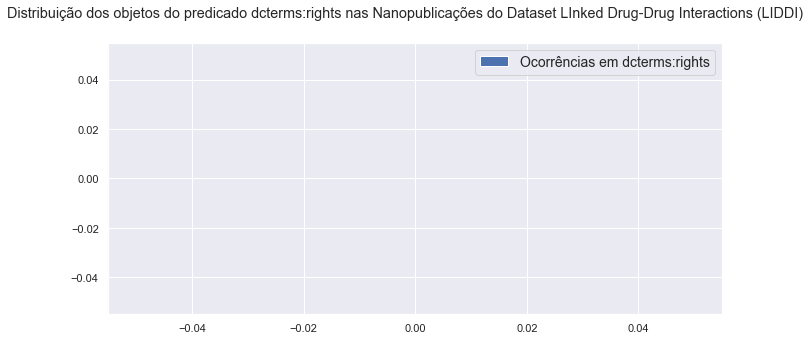

In [135]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(liddiRightsCont[0], liddiRightsCont[1], label = 'Ocorrências em dcterms:rights')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rights nas Nanopublicações do Dataset LInked Drug-Drug Interactions (LIDDI)");
plt.show()


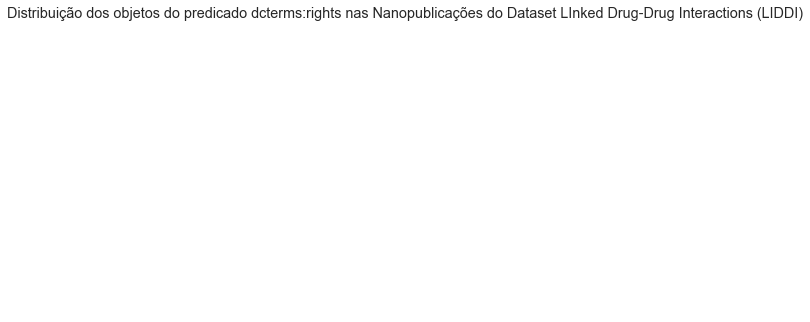

In [138]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(liddiRightsCont[1], labels=liddiRightsCont[0], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dcterms:rights nas Nanopublicações do Dataset LInked Drug-Drug Interactions (LIDDI)");

In [140]:
# Contagem de nanopublicações usando dcterms:rightsHolder no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
"""

results = queryLIDDI(query)
liddiNumRightsHolder = get_array(results)
print(liddiNumRightsHolder)

[0]


In [141]:
# Lista os diferentes objetos do predicado dcterms:rightsHolder no Publication Info e conta quantas ocorrências há
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?rightsHolder (count(?rightsHolder) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np (dcterms:rightsHolder) ?rightsHolder .
  }
}
GROUP BY ?rightsHolder
"""

results = queryLIDDI(query)
liddiRightsHolderCont = get_array5(results)
print(liddiRightsHolderCont)

[[], []]


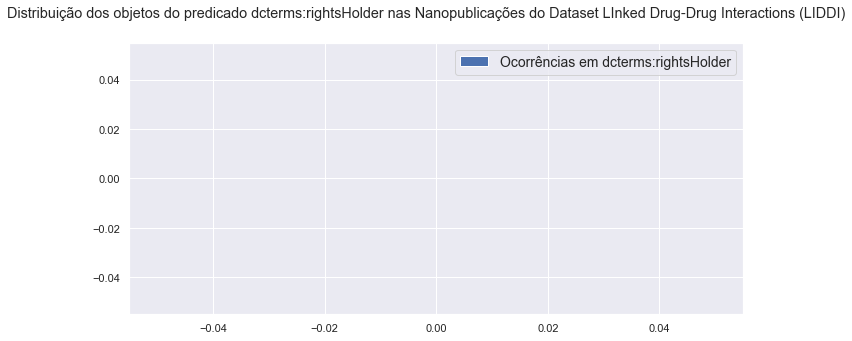

In [142]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(liddiRightsHolderCont[0], liddiRightsHolderCont[1], label = 'Ocorrências em dcterms:rightsHolder')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset LInked Drug-Drug Interactions (LIDDI)");
plt.show()

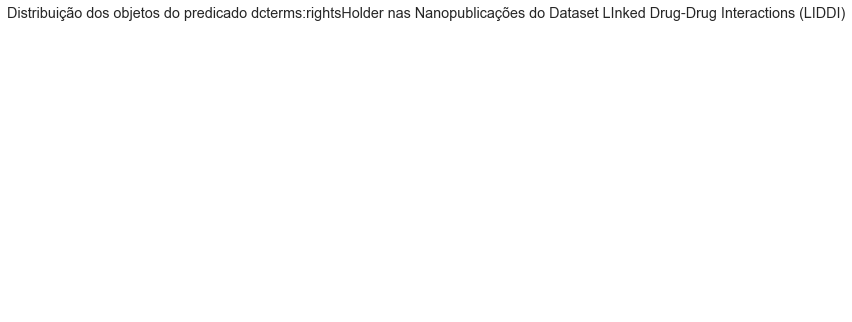

In [143]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(liddiRightsHolderCont[1], labels=liddiRightsHolderCont[0], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dcterms:rightsHolder nas Nanopublicações do Dataset LInked Drug-Drug Interactions (LIDDI)");

In [144]:
# Contagem de nanopublicações usando dcterms:licence no grafo Publication Info
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select (count(*) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
"""

results = queryLIDDI(query)
liddiNumLicence = get_array(results)
print(liddiNumLicence)

[88087]


In [146]:
# Lista os diferentes objetos do predicado dcterms:licence no Publication Info e conta quantas ocorrências há
# Interessante notar que bate com o número total de nanopublicações existentes no dataset
# Indicando que todas as nanopublicações declararam o mesmo objeto para dcterms:licence
query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?licence (count(?licence) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
GROUP BY ?licence
"""

results = queryLIDDI(query)
liddiLicenceCont = get_array4(results)
print(liddiLicenceCont)

[['http://creativecommons.org/licenses/by/3.0/'], [88087]]


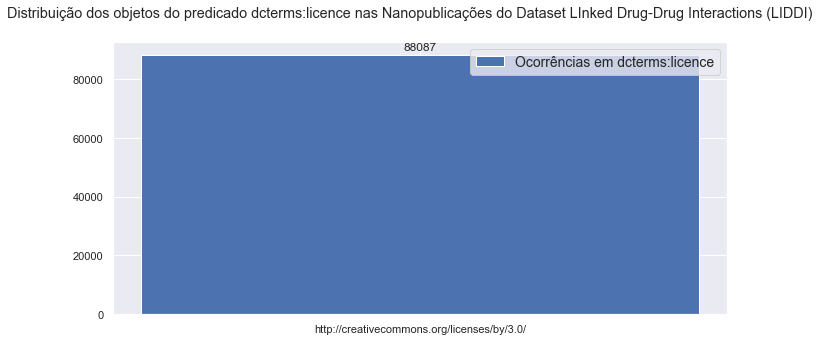

In [147]:
fig, ax = plt.subplots(figsize=(11,5)) # (width, height)
rect = ax.bar(liddiLicenceCont[0], liddiLicenceCont[1], label = 'Ocorrências em dcterms:licence')
ax.legend(fontsize = 14)
ax.bar_label(rect, padding=3)
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset LInked Drug-Drug Interactions (LIDDI)");
plt.show()

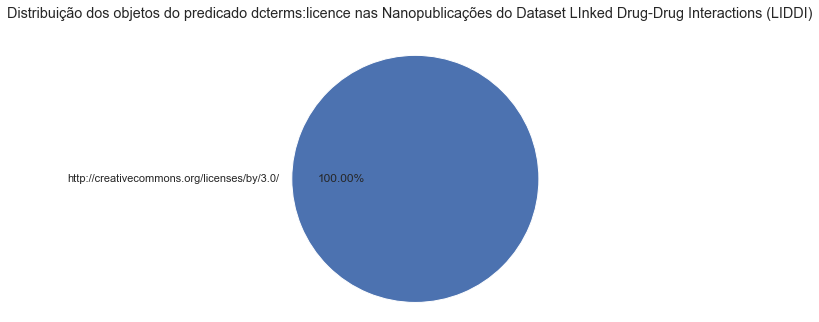

In [148]:
# Exibição do resultado em grafico de pizza
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(liddiLicenceCont[1], labels=liddiLicenceCont[0], autopct='%1.2f%%', normalize=True)
ax.axis('equal') # mantenha um circulo
fig.suptitle("Distribuição dos objetos do predicado dcterms:licence nas Nanopublicações do Dataset LInked Drug-Drug Interactions (LIDDI)");
plt.show()

## All Datasets in One Picture ##

In [351]:
with open('distributionAll.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Graphs', 'Triples']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Graphs', 'Triples'])
    
    # For NeXtProt DataSet
    for t in nxtHeadTriples:
        writer.writerow(['neXtProt 19001_20000', 'Head', t])
    for t in nxtAssertionTriples:
        writer.writerow(['neXtProt 19001_20000', 'Assertion', t])
    for t in nxtProvenanceTriples:
        writer.writerow(['neXtProt 19001_20000', 'Provenance', t])
    for t in nxtPubInfoTriples:
        writer.writerow(['neXtProt 19001_20000', 'PublicationInfo', t])
    
    #For Wikipathways dataset
    for t in wpHeadTriples:
        writer.writerow(['WikiPathways 20170513', 'Head', t])
    for t in wpAssertionTriples:
        writer.writerow(['WikiPathways 20170513', 'Assertion', t])
    for t in wpProvenanceTriples:
        writer.writerow(['WikiPathways 20170513', 'Provenance', t])
    for t in wpPubInfoTriples:
        writer.writerow(['WikiPathways 20170513', 'PublicationInfo', t])
        
    #For DisGeNet Dataset
    for t in dgHeadTriples:
        writer.writerow(['DisGeNET 4.0', 'Head', t])
    for t in dgAssertionTriples:
        writer.writerow(['DisGeNET 4.0', 'Assertion', t])
    for t in dgProvenanceTriples:
        writer.writerow(['DisGeNET 4.0', 'Provenance', t])
    for t in dgPubInfoTriples:
        writer.writerow(['DisGeNET 4.0', 'PublicationInfo', t])
        
    #For OpenBell Dataset
    for t in openBellHeadTriples:
        writer.writerow(['OpenBell 20131211', 'Head', t])
    for t in openBellAssertionTriples:
        writer.writerow(['OpenBell 20131211', 'Assertion', t])
    for t in openBellProvenanceTriples:
        writer.writerow(['OpenBell 20131211', 'Provenance', t])
    for t in openBellPubInfoTriples:
        writer.writerow(['OpenBell 20131211', 'PublicationInfo', t])
        
    #For LIDDI Dataset
    for t in liddiHeadTriples:
        writer.writerow(['LIDDI V1.02', 'Head', t])
    for t in liddiAssertionTriples:
        writer.writerow(['LIDDI V1.02', 'Assertion', t])
    for t in liddiProvenanceTriples:
        writer.writerow(['LIDDI V1.02', 'Provenance', t])
    for t in liddiPubInfoTriples:
        writer.writerow(['LIDDI V1.02', 'PublicationInfo', t])

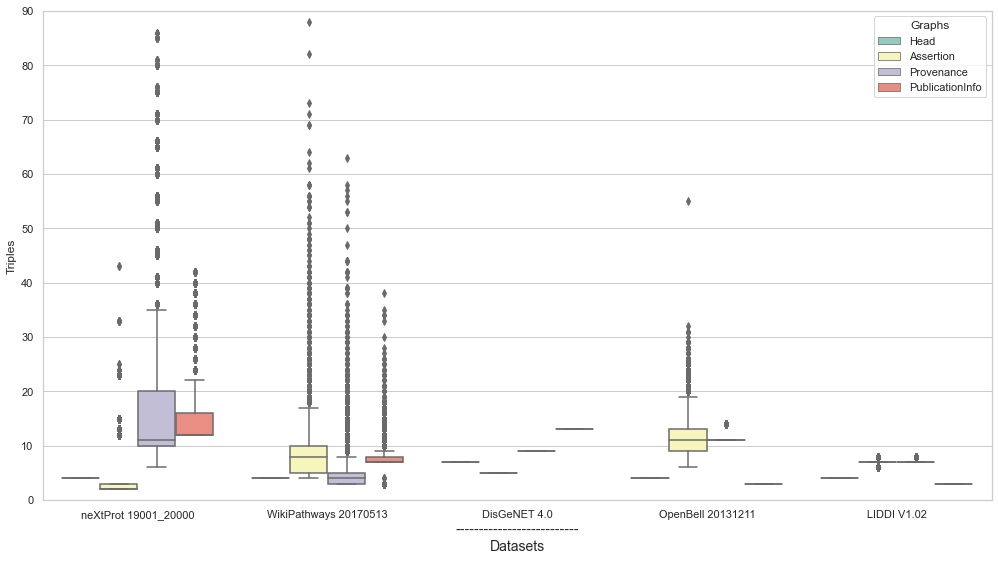

In [352]:
dataAll = pd.read_csv('distributionAll.csv')

sns.set(rc={'figure.figsize':(17,9)})
sns.set(style="whitegrid")
ax = sns.boxplot(x="DataSets", y="Triples", hue="Graphs", data=dataAll, palette="Set3")
#ax.axes.set_title("Frequency distribution of the number of triples in each graph of a nanopublication\n",fontsize=25)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)

#the y-axis is cut-off at a count of 90. The WikiPathways nanopublications include up to 1,001 triples in the assertion graph.
ax.set_ylim(0, 90);

Text(0.5, 0, '--------------------------\nDatasets')

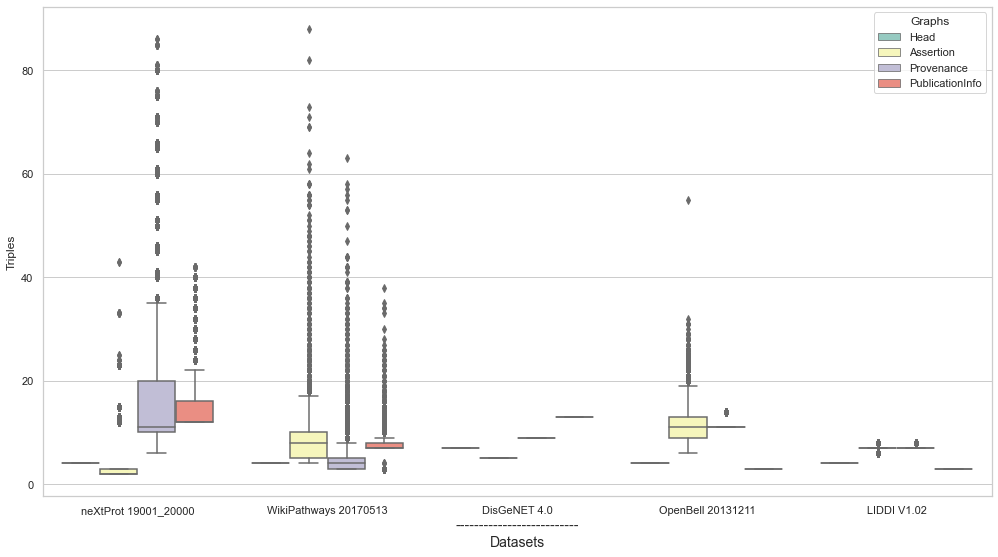

In [353]:
#Include graphs without y-axis cutoff at 90
dataAll = pd.read_csv('distributionAll.csv')

sns.set(rc={'figure.figsize':(17,9)})
sns.set(style="whitegrid")
ax = sns.boxplot(x="DataSets", y="Triples", hue="Graphs", data=dataAll, palette="Set3")
#ax.axes.set_title("Frequency distribution of the number of triples in each graph of a nanopublication\n",fontsize=25)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)

## Average Triples Count 

Text(0, 0.5, 'Average Triples Count')

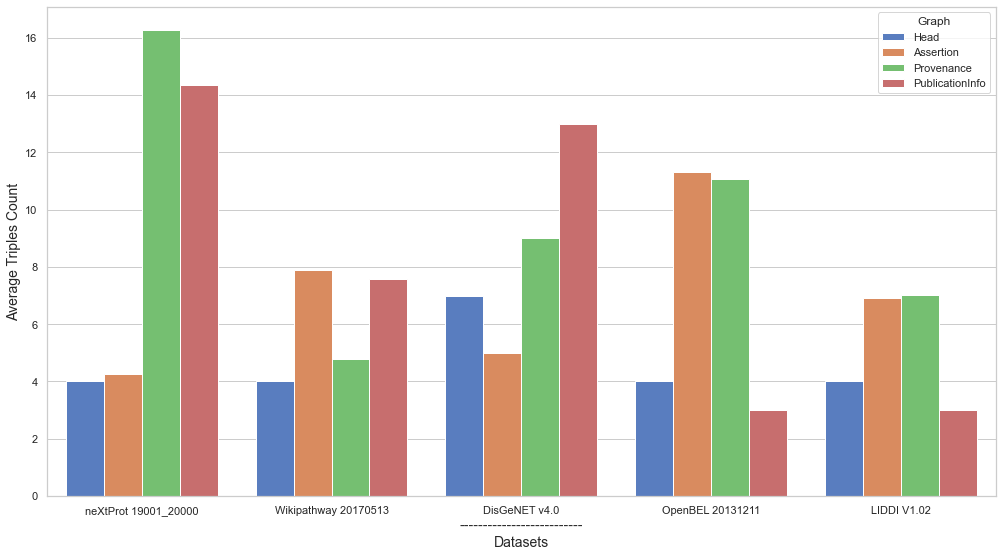

In [354]:
nxtHeadTriplesAvg = average(nxtHeadTriples)
nxtAssertionTriplesAvg = average(nxtAssertionTriples)
nxtProvenanceTriplesAvg = average(nxtProvenanceTriples)
nxtPubInfoTriplesAvg = average(nxtPubInfoTriples)

wpHeadTriplesAvg = average(wpHeadTriples)
wpAssertionTriplesAvg = average(wpAssertionTriples)
wpProvenanceTriplesAvg = average(wpProvenanceTriples)
wpPubInfoTriplesAvg = average(wpPubInfoTriples)

dgHeadTriplesAvg = average(dgHeadTriples)
dgAssertionTriplesAvg = average(dgAssertionTriples)
dgProvenanceTriplesAvg = average(dgProvenanceTriples)
dgPubInfoTriplesAvg = average(dgPubInfoTriples)


openBellHeadTriplesAvg = average(openBellHeadTriples)
openBellAssertionTriplesAvg = average(openBellAssertionTriples)
openBellProvenanceTriplesAvg = average(openBellProvenanceTriples)
openBellPubInfoTriplesAvg = average(openBellPubInfoTriples)


liddiHeadTriplesAvg = average(liddiHeadTriples)
liddiAssertionTriplesAvg = average(liddiAssertionTriples)
liddiProvenanceTriplesAvg = average(liddiProvenanceTriples)
liddiPubInfoTriplesAvg = average(liddiPubInfoTriples)



df = pd.DataFrame(columns=["Dataset","Graph","Triples"], 
                  data=[['neXtProt 19001_20000', 'Head', nxtHeadTriplesAvg],
                        ['neXtProt 19001_20000', 'Assertion', nxtAssertionTriplesAvg],
                        ['neXtProt 19001_20000', 'Provenance', nxtProvenanceTriplesAvg],
                        ['neXtProt 19001_20000', 'PublicationInfo', nxtPubInfoTriplesAvg],
                        ['Wikipathway 20170513', 'Head', wpHeadTriplesAvg],
                        ['Wikipathway 20170513', 'Assertion', wpAssertionTriplesAvg],
                        ['Wikipathway 20170513', 'Provenance', wpProvenanceTriplesAvg],
                        ['Wikipathway 20170513', 'PublicationInfo', wpPubInfoTriplesAvg],
                        ['DisGeNET v4.0', 'Head', dgHeadTriplesAvg],
                        ['DisGeNET v4.0', 'Assertion', dgAssertionTriplesAvg],
                        ['DisGeNET v4.0', 'Provenance', dgProvenanceTriplesAvg],
                        ['DisGeNET v4.0', 'PublicationInfo', dgPubInfoTriplesAvg],
                        ['OpenBEL 20131211', 'Head', openBellHeadTriplesAvg],
                        ['OpenBEL 20131211', 'Assertion', openBellAssertionTriplesAvg],
                        ['OpenBEL 20131211', 'Provenance', openBellProvenanceTriplesAvg],
                        ['OpenBEL 20131211', 'PublicationInfo', openBellPubInfoTriplesAvg],
                        ['LIDDI V1.02', 'Head', liddiHeadTriplesAvg],
                        ['LIDDI V1.02', 'Assertion', liddiAssertionTriplesAvg],
                        ['LIDDI V1.02', 'Provenance', liddiProvenanceTriplesAvg],
                        ['LIDDI V1.02', 'PublicationInfo', liddiPubInfoTriplesAvg]
                        ])

sns.set(style="whitegrid")

ax = sns.barplot(x="Dataset", y="Triples", hue="Graph", data=df, ci='sd', palette="muted")
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
ax.axes.set_ylabel('Average Triples Count', fontsize=14)


## Head Graph for all Datasets

In [355]:
with open('distributionHead.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Triples']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Triples'])
    
    # For NeXtProt DataSet
    for t in nxtHeadTriples:
        writer.writerow(['neXtProt 19001_20000', t])
        
    #For Wikipathways dataset
    for t in wpHeadTriples:
        writer.writerow(['Wikipathway 20170513', t])
        
    #For DisGeNet Dataset
    for t in dgHeadTriples:
        writer.writerow(['DisGeNET v4.0', t])
        
    #For OpenBell Dataset
    for t in openBellHeadTriples:
        writer.writerow(['OpenBEL 20131211', t])
        
    #For LIDDI Dataset
    for t in liddiHeadTriples:
        writer.writerow(['LIDDI V1.02', t])

Text(0.5, 0, '--------------------------\nDatasets')

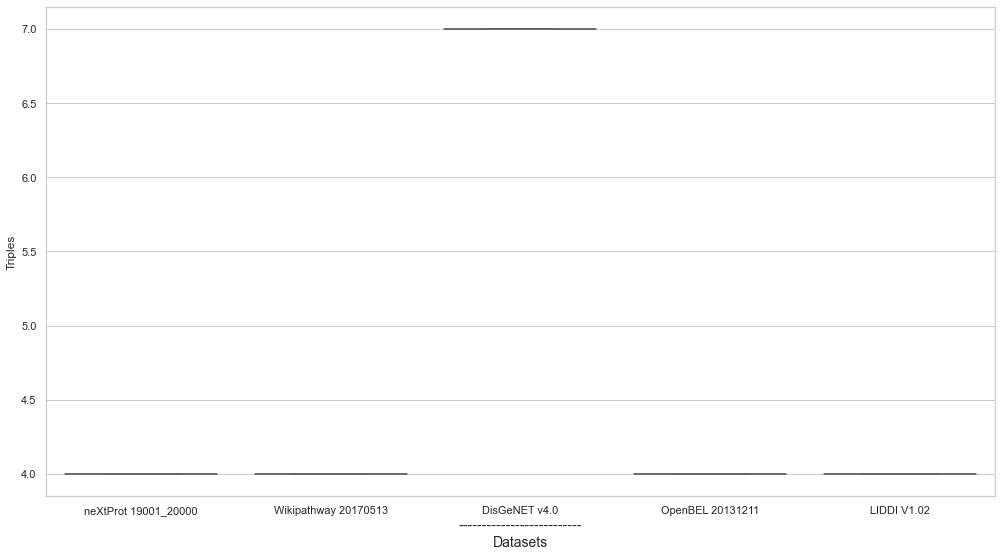

In [356]:
dataAssertions = pd.read_csv('distributionHead.csv')

sns.set(style="whitegrid")
#sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="DataSets", y="Triples", data=dataAssertions, palette="Set3")
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
#ax.axes.set_title("Head Graph Distribution",fontsize=30)
#ax.set_ylim(0, 10);

## Assertion Graph for all Datasets ##

In [357]:
with open('distributionAssertion.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Triples']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Triples'])
    
    # For NeXtProt DataSet
    for t in nxtAssertionTriples:
        writer.writerow(['neXtProt 19001_20000', t])
        
    #For Wikipathways dataset
    for t in wpAssertionTriples:
        writer.writerow(['Wikipathway 20170513', t])
        
    #For DisGeNet Dataset
    for t in dgAssertionTriples:
        writer.writerow(['DisGeNET v4.0', t])
        
    #For OpenBell Dataset
    for t in openBellAssertionTriples:
        writer.writerow(['OpenBEL 20131211', t])
        
    #For LIDDI Dataset
    for t in liddiAssertionTriples:
        writer.writerow(['LIDDI V1.02', t])
    

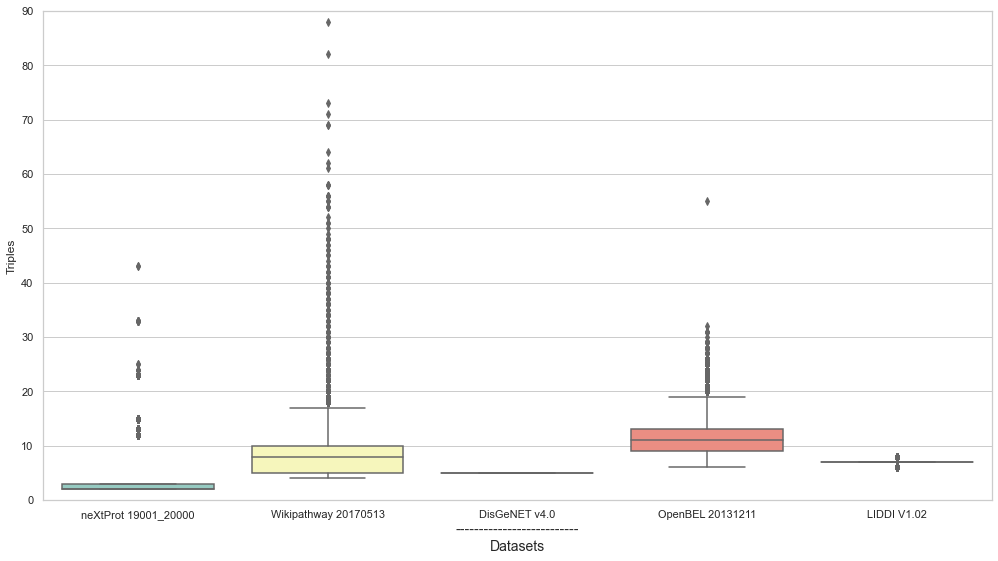

In [358]:
dataAssertions = pd.read_csv('distributionAssertion.csv')

sns.set(style="whitegrid")
#sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="DataSets", y="Triples", data=dataAssertions, palette="Set3")
#ax.axes.set_title("Assertion Graph Distribution",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
ax.set_ylim(0, 90);

## Average and outliers

In [359]:


# For NeXtProt DataSet
avg = statistics.median(nxtAssertionTriples) #round(sum(nxtAssertionTriples) / len(nxtAssertionTriples), 2)
#print(avg)
outliers = 0
for t in nxtAssertionTriples:
    if t > avg:
        outliers = outliers + 1
print('nextProt: ' + str(outliers) + ' ' + str(avg) + ' avg.')

# For Wikipathways DataSet
avg = statistics.median(wpAssertionTriples) #round(sum(wpAssertionTriples) / len(wpAssertionTriples), 2)
#print(avg)
outliers = 0
for t in wpAssertionTriples:
    if t > avg:
        outliers = outliers + 1
print('WP: ' + str(outliers) + ' ' + str(avg) + ' avg.')

# For DisGetNet DataSet
avg = statistics.median(dgAssertionTriples) #round(sum(dgAssertionTriples) / len(dgAssertionTriples), 2)
#print(avg)
outliers = 0
for t in dgAssertionTriples:
    if t > avg:
        outliers = outliers + 1
print('DisGeNET: ' + str(outliers) + ' ' + str(avg) + ' avg.')

# For OpenBEL DataSet
avg = statistics.median(openBellAssertionTriples) #round(sum(openBellAssertionTriples) / len(openBellAssertionTriples), 2)
#print(avg)
outliers = 0
for t in openBellAssertionTriples:
    if t > avg:
        outliers = outliers + 1
print('OpenBel: ' + str(outliers) + ' ' + str(avg) + ' avg.')

# For LIDDI DataSet
avg = statistics.median(liddiAssertionTriples) #round(sum(liddiAssertionTriples) / len(liddiAssertionTriples), 2)
#print(avg)
outliers = 0
for t in liddiAssertionTriples:
    if t > avg:
        outliers = outliers + 1
print('LIDDI: ' + str(outliers) + ' ' + str(avg) + ' avg.')

nextProt: 18108 2.0 avg.
WP: 4756 8 avg.
DisGeNET: 0 5 avg.
OpenBel: 21454 11.0 avg.
LIDDI: 306 7 avg.


## Provenance Graph for all Datasets ##

In [360]:
with open('distributionProvenance.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Triples']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Triples'])
    
    # For NeXtProt DataSet
    for t in nxtProvenanceTriples:
        writer.writerow(['neXtProt 19001_20000', t])
    
    #For Wikipathways dataset
    for t in wpProvenanceTriples:
        writer.writerow(['Wikipathway 20170513', t])
        
    #For DisGeNet Dataset
    for t in dgProvenanceTriples:
        writer.writerow(['DisGeNET v4.0', t])
        
    #For OpenBell Dataset
    for t in openBellProvenanceTriples:
        writer.writerow(['OpenBEL 20131211', t])
        
    #For LIDDI Dataset
    for t in liddiProvenanceTriples:
        writer.writerow(['LIDDI V1.02', t])

Text(0.5, 0, '--------------------------\nDatasets')

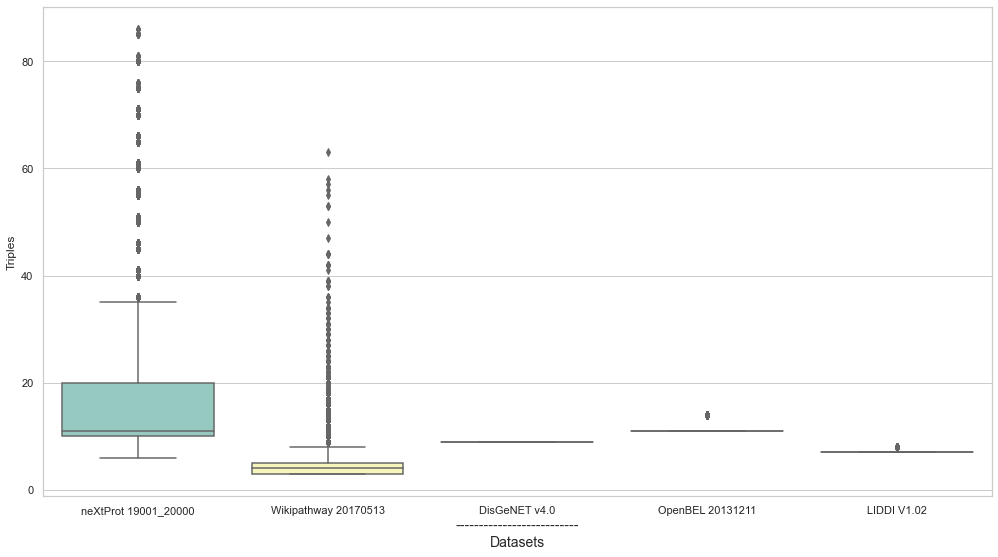

In [361]:
dataProvenance = pd.read_csv('distributionProvenance.csv')

sns.set(style="whitegrid")
#sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="DataSets", y="Triples", data=dataProvenance, palette="Set3")
#ax.axes.set_title("Provenance Graph Distribution",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
#ax.set_ylim(0, 90);

In [362]:
#Median and outliers
# For NeXtProt DataSet
avg = statistics.median(nxtProvenanceTriples) #round(sum(nxtAssertionTriples) / len(nxtAssertionTriples), 2)
#print(avg)
outliers = 0
for t in nxtProvenanceTriples:
    if t > avg:
        outliers = outliers + 1
print('nextProt: ' + str(outliers) + ' ' + str(avg) + ' avg.')

# For Wikipathways DataSet
avg = statistics.median(wpProvenanceTriples) #round(sum(wpAssertionTriples) / len(wpAssertionTriples), 2)
#print(avg)
outliers = 0
for t in wpProvenanceTriples:
    if t > avg:
        outliers = outliers + 1
print('WP: ' + str(outliers) + ' ' + str(avg) + ' avg.')

# For DisGetNet DataSet
avg = statistics.median(dgProvenanceTriples) #round(sum(dgAssertionTriples) / len(dgAssertionTriples), 2)
#print(avg)
outliers = 0
for t in dgProvenanceTriples:
    if t > avg:
        outliers = outliers + 1
print('DisGeNET: ' + str(outliers) + ' ' + str(avg) + ' avg.')

# For OpenBEL DataSet
avg = statistics.median(openBellProvenanceTriples) #round(sum(openBellAssertionTriples) / len(openBellAssertionTriples), 2)
#print(avg)
outliers = 0
for t in openBellProvenanceTriples:
    if t > avg:
        outliers = outliers + 1
print('OpenBel: ' + str(outliers) + ' ' + str(avg) + ' avg.')

# For LIDDI DataSet
avg = statistics.median(liddiProvenanceTriples) #round(sum(liddiAssertionTriples) / len(liddiAssertionTriples), 2)
#print(avg)
outliers = 0
for t in liddiProvenanceTriples:
    if t > avg:
        outliers = outliers + 1
print('LIDDI: ' + str(outliers) + ' ' + str(avg) + ' avg.')

nextProt: 27954 11.0 avg.
WP: 5346 4 avg.
DisGeNET: 0 9 avg.
OpenBel: 965 11.0 avg.
LIDDI: 316 7 avg.


## Publication Information Graph for all Datasets ##

In [363]:
with open('distributionPubInfo.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Triples']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Triples'])
    
    # For NeXtProt DataSet
    for t in nxtPubInfoTriples:
        writer.writerow(['neXtProt 19001_20000', t])
    
    #For Wikipathways dataset
    for t in wpPubInfoTriples:
        writer.writerow(['Wikipathway 20170513', t])
        
    #For DisGeNet Dataset
    for t in dgPubInfoTriples:
        writer.writerow(['DisGeNET v4.0', t])
        
    #For OpenBell Dataset
    for t in openBellPubInfoTriples:
        writer.writerow(['OpenBEL 20131211', t])
        
    #For LIDDI Dataset
    for t in liddiPubInfoTriples:
        writer.writerow(['LIDDI V1.02', t])

Text(0.5, 0, '--------------------------\nDatasets')

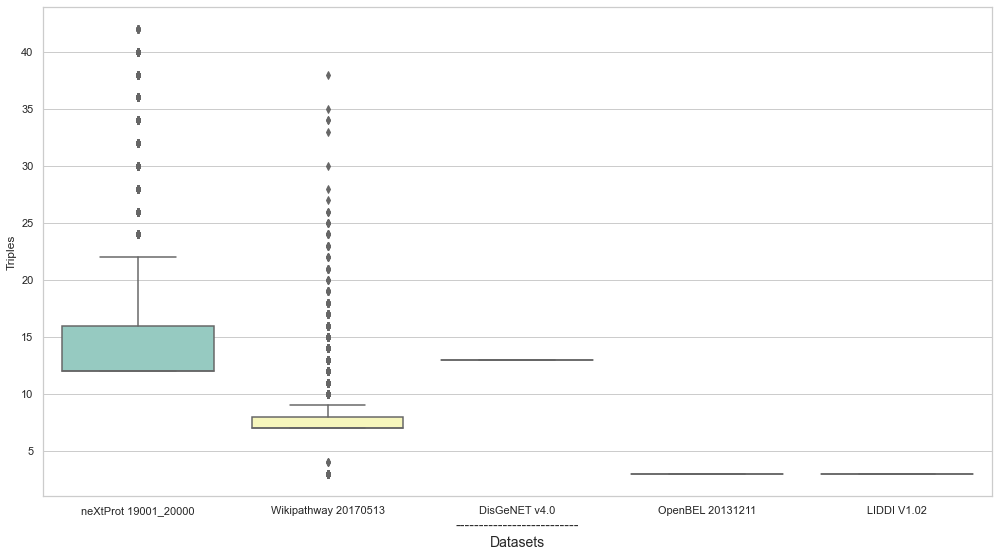

In [364]:
dataPubInfo = pd.read_csv('distributionPubInfo.csv')

sns.set(style="whitegrid")
#sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.boxplot(x="DataSets", y="Triples", data=dataPubInfo, palette="Set3")
#ax.axes.set_title("Publication Information Graph Distribution",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
#ax.set_ylim(0, 90);

In [365]:
#Median and outliers
# For NeXtProt DataSet
avg = statistics.median(nxtPubInfoTriples) #round(sum(nxtAssertionTriples) / len(nxtAssertionTriples), 2)
#print(avg)
outliers = 0
for t in nxtPubInfoTriples:
    if t > avg:
        outliers = outliers + 1
print('nextProt: ' + str(outliers) + ' ' + str(avg) + ' avg.')

# For Wikipathways DataSet
avg = statistics.median(wpPubInfoTriples) #round(sum(wpAssertionTriples) / len(wpAssertionTriples), 2)
#print(avg)
outliers = 0
for t in wpPubInfoTriples:
    if t > avg:
        outliers = outliers + 1
print('WP: ' + str(outliers) + ' ' + str(avg) + ' avg.')

# For DisGetNet DataSet
avg = statistics.median(dgPubInfoTriples) #round(sum(dgAssertionTriples) / len(dgAssertionTriples), 2)
#print(avg)
outliers = 0
for t in dgPubInfoTriples:
    if t > avg:
        outliers = outliers + 1
print('DisGeNET: ' + str(outliers) + ' ' + str(avg) + ' avg.')

# For OpenBEL DataSet
avg = statistics.median(openBellPubInfoTriples) #round(sum(openBellAssertionTriples) / len(openBellAssertionTriples), 2)
#print(avg)
outliers = 0
for t in openBellPubInfoTriples:
    if t > avg:
        outliers = outliers + 1
print('OpenBel: ' + str(outliers) + ' ' + str(avg) + ' avg.')

# For LIDDI DataSet
avg = statistics.median(liddiPubInfoTriples) #round(sum(liddiAssertionTriples) / len(liddiAssertionTriples), 2)
#print(avg)
outliers = 0
for t in liddiPubInfoTriples:
    if t > avg:
        outliers = outliers + 1
print('LIDDI: ' + str(outliers) + ' ' + str(avg) + ' avg.')

nextProt: 26871 12.0 avg.
WP: 5709 7 avg.
DisGeNET: 0 13 avg.
OpenBel: 0 3.0 avg.
LIDDI: 0 3 avg.


## Authors Distribution in all datasets

In [367]:
#Getting All authors from DisGetNET
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix npx: <http://purl.org/nanopub/x/>
prefix pav: <http://purl.org/pav/>
prefix prov: <http://www.w3.org/ns/prov#>

select (count(distinct ?author) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (pav:authoredBy) ?author .
  }
}GROUP By ?np"""

results = queryDisGeNET(query)
dgAuthors = get_array(results)
print(dgAuthors)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [368]:
#Getting All authors from neXtProt
query = """
prefix np: <http://www.nanopub.org/nschema#>

select (count(distinct ?author) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np <http://swan.mindinformatics.org/ontologies/1.2/pav/authoredBy> ?author .
  }
}GROUP By ?np"""

results = queryNeXtProt(query)
nxtAuthors = get_array(results)
print(nxtAuthors)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [369]:
#Getting All authors from Wikipathways
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix npx: <http://purl.org/nanopub/x/>
prefix pav: <http://purl.org/pav/>
prefix prov: <http://www.w3.org/ns/prov#>

select (count(distinct ?author) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (pav:authoredBy) ?author .
  }
}GROUP By ?np"""

results = queryWP(query)
wikiAuthors = get_array(results)
print(wikiAuthors)
#Note: Wikipathways has no authors

[]


In [370]:
#Getting All authors from open bel large & small corpus
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix pav: <http://purl.org/pav/>

select (count(distinct ?author) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasProvenance ?prov .
  }
  graph ?prov {
    ?s (pav:authoredBy) ?author .
  }
}GROUP By ?np"""

results = queryOpenBellLarge(query)
belLargeAuthors = get_array(results)
print(belLargeAuthors)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix pav: <http://purl.org/pav/>

select (count(distinct ?author) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasProvenance ?prov .
  }
  graph ?prov {
    ?s (pav:authoredBy) ?author .
  }
}GROUP By ?np"""

#results = queryOpenBellSmall(query)
#belSmallAuthors = get_array(results)


openBellAuthors = []
openBellAuthors.extend(belLargeAuthors)
#openBellAuthors.extend(belSmallAuthors)
openBellAuthors.sort()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [35]:
# LIDDI has no authors beceause its Software Generated.

In [371]:
# All Data in the csv File
with open('distributionAuthors.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Count']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Count'])
    
    # For NeXtProt DataSet
    for t in nxtAuthors:
        writer.writerow(['neXtProt 19001_20000', t])
        
    #For Wikipathways dataset
    if (len(wikiAuthors) > 0):
        for t in wikiAuthors:
            writer.writerow(['WikiPathways 20170513', t])
    else:
        writer.writerow(['WikiPathways 20170513', 0])
        
    #For DisGeNet Dataset
    for t in dgAuthors:
        writer.writerow(['DisGeNET 4.0', t])
        
    #For OpenBell Dataset
    for t in openBellAuthors:
        writer.writerow(['OpenBell 20131211', t])
        
    #LIDDI
    writer.writerow(['LIDDI V1.02', 0])

Text(0.5, 0, '--------------------------\nDatasets')

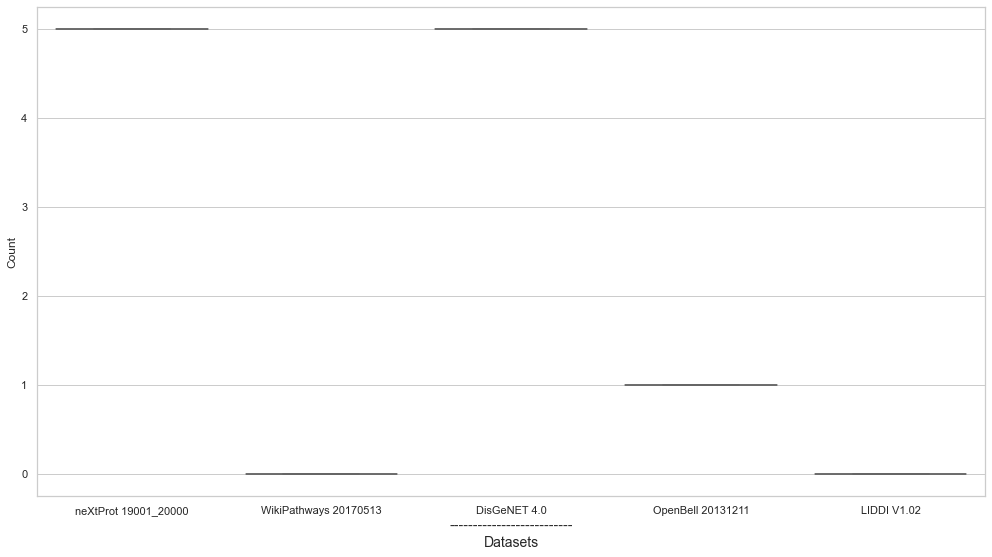

In [372]:
dataAuthors = pd.read_csv('distributionAuthors.csv')

sns.set(style="whitegrid")
ax = sns.boxplot(x="DataSets", y="Count", data=dataAuthors, palette="Set3")
#ax.axes.set_title("Author Distribution",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
#ax.set_ylim(0, 10);

## Creators Distribution in all datasets

In [373]:
#Getting All creators from DisGetNET
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>
prefix pav: <http://purl.org/pav/>

select (count(distinct ?creator) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:creator|dce:creator|pav:createdBy) ?creator .
  }
}GROUP By ?np"""

results = queryDisGeNET(query)
dgCreators = get_array(results)
print(dgCreators)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [374]:
#Getting All creators from neXtProt
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>
prefix pav: <http://purl.org/pav/>

select (count(distinct ?creator) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:creator|dce:creator|pav:createdBy) ?creator .
  }
}GROUP By ?np"""

results = queryNeXtProt(query)
nxtCreators = get_array(results)
print(nxtCreators)

# neXtProt has no creator 
# Describe Nanopublication
#:NX_Q9UKF6-1_PTM-0207_2.RA-3WCl5c7ZO6xYamZ7X7jL0Ahfe3zQ2bBRH68P66hHUI
#        a                      np:Nanopublication ;
#        dcterms:created        "2014-09-19T00:00:00Z"^^xsd:dateTime ;
#        dcterms:rights         <http://creativecommons.org/licenses/by/3.0/> ;
#        dcterms:rightsHolder   <http://nextprot.org> ;
#        prv:usedData           "neXtProt database" ;
#        <http://swan.mindinformatics.org/ontologies/1.2/pav/authoredBy>
#          "CALIPHO project" ;
#        <http://swan.mindinformatics.org/ontologies/1.2/pav/authoredBy>
#        <http://orcid.org/0000-0001-6710-1373> , <http://orcid.org/0000-0002-1303-2189> , <http://orcid.org/0000-0003-1813-6857> , <http://orcid.org/0000-0001-6818-334X> ;
#        <http://swan.mindinformatics.org/ontologies/1.2/pav/versionNumber>
#        "1" ;
#      np:hasAssertion        <http://www.nextprot.org/nanopubs#NX_Q9UKF6-1_PTM-0207_2.RA-3WCl5c7ZO6xYamZ7X7jL0Ahfe3zQ2bBRH68P66hHUI#assertion> ;
#      np:hasProvenance       <http://www.nextprot.org/nanopubs#NX_Q9UKF6-1_PTM-0207_2.RA-3WCl5c7ZO6xYamZ7X7jL0Ahfe3zQ2bBRH68P66hHUI#provenance> ;
#      np:hasPublicationInfo  <http://www.nextprot.org/nanopubs#NX_Q9UKF6-1_PTM-0207_2.RA-3WCl5c7ZO6xYamZ7X7jL0Ahfe3zQ2bBRH68P66hHUI#pubinfo> ;
#      prov:wasGeneratedBy    <http://www.nextprot.org/nanopubs#NX_Q9UKF6-1_PTM-0207_2.RA-3WCl5c7ZO6xYamZ7X7jL0Ahfe3zQ2bBRH68P66hHUI#_5> .

[]


In [375]:
#Getting All creators from Wikipathways
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>
prefix pav: <http://purl.org/pav/>

select (count(distinct ?creator) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:creator|dce:creator|pav:createdBy) ?creator .
  }
}GROUP By ?np"""

results = queryWP(query)
wikiCreators = get_array(results)
print(wikiCreators)

#Describe nanopublication
#<http://purl.org/np/RASqUFyaiZdd8viHLNjoTtdv3SvoTJ-Qpx4DpfcXPHQSg>
#        a                      np:Nanopublication ;
#        dcterms:created        "2017-05-08T15:57:43.151+02:00"^^xsd:dateTime ;
#        dcterms:rights         <https://creativecommons.org/licenses/by/3.0/> ;
#        np:hasAssertion        <http://purl.org/np/RASqUFyaiZdd8viHLNjoTtdv3SvoTJ-Qpx4DpfcXPHQSg#assertion> ;
#        np:hasProvenance       <http://purl.org/np/RASqUFyaiZdd8viHLNjoTtdv3SvoTJ-Qpx4DpfcXPHQSg#provenance> ;
#        np:hasPublicationInfo  <http://purl.org/np/RASqUFyaiZdd8viHLNjoTtdv3SvoTJ-Qpx4DpfcXPHQSg#publicationInfo> ;
#        prov:wasDerivedFrom    <http://identifiers.org/wikipathways/WP176_r85063> .

[]


In [376]:
#Getting All creators from large and small corpus
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>
prefix pav: <http://purl.org/pav/>

select (count(distinct ?creator) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:creator|dce:creator|pav:createdBy) ?creator .
  }
}GROUP By ?np"""

results = queryOpenBellLarge(query)
belLargeCreators = get_array(results)
print(belLargeCreators)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>
prefix pav: <http://purl.org/pav/>

select (count(distinct ?creator) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:creator|dce:creator|pav:createdBy) ?creator .
  }
}GROUP By ?np"""

#results = queryOpenBellSmall(query)
#belSmallCreators = get_array(results)


openBellCreators = []
openBellCreators.extend(belLargeCreators)
#openBellCreators.extend(belSmallCreators)
openBellCreators.sort()

#Describe Nanopublication

#<http://www.tkuhn.ch/bel2nanopub/RAlKFUbz4ZPgXiJNsebuH06skrZbx0Ix7XSWK5z4u69v4>
#        a                      np:Nanopublication ;
#        dct:created            "2014-07-03T14:31:25.409+02:00"^^xsd:dateTime ;
#        pav:createdBy          orcid:0000-0002-1267-0234 , orcid:0000-0001-6818-334X ;
#        np:hasAssertion        <http://www.tkuhn.ch/bel2nanopub/RAlKFUbz4ZPgXiJNsebuH06skrZbx0Ix7XSWK5z4u69v4#assertion> ;
#        np:hasProvenance       <http://www.tkuhn.ch/bel2nanopub/RAlKFUbz4ZPgXiJNsebuH06skrZbx0Ix7XSWK5z4u69v4#provenance> ;
#        np:hasPublicationInfo  <http://www.tkuhn.ch/bel2nanopub/RAlKFUbz4ZPgXiJNsebuH06skrZbx0Ix7XSWK5z4u69v4#pubinfo> .

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [377]:
#Getting All creators from LIDDI
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix prov: <http://www.w3.org/ns/prov#>

select (count(distinct ?creator) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (prov:wasAttributedTo) ?creator .
  }
}GROUP By ?np"""

results = queryLIDDI(query)
liddiCreators = get_array(results)
print(liddiCreators)

#Describe Nanopublication
#ddir:EID0002_nanopub  a        np:Nanopublication ;
#        dcterms:license        <http://creativecommons.org/licenses/by/3.0/> ;
#        np:hasAssertion        ddir:EID0002_nanopubassertion ;
#        np:hasProvenance       ddir:EID0002_nanopubprovenance ;
#        np:hasPublicationInfo  ddir:EID0002_nanopubpublicationInfo ;
#        prov:generatedAtTime   "2016-04-06T15:01:38.194767"^^xsd:dateTime ;
#        prov:wasAttributedTo   orcid:0000-0001-8499-824X .

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [378]:
# All Data in the csv File
with open('distributionCreators.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Count']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Count'])
    
    # For NeXtProt DataSet
    if (len(nxtCreators) > 0):
        for t in nxtCreators:
            writer.writerow(['NeXtProt', t])
    else:
        writer.writerow(['NeXtProt', 0])
        
    #For Wikipathways dataset
    if (len(wikiCreators) > 0):
        for t in wikiCreators:
            writer.writerow(['WikiPathways 20170513', t])
    else:
        writer.writerow(['WikiPathways 20170513', 0])   
        
    #For DisGeNet Dataset
    for t in dgCreators:
        writer.writerow(['DisGeNET 4.0', t])
        
    #For OpenBell Dataset
    for t in openBellCreators:
        writer.writerow(['OpenBell 20131211', t])

    #For LIDDI Dataset
    for t in liddiCreators:
        writer.writerow(['LIDDI V1.02', t])

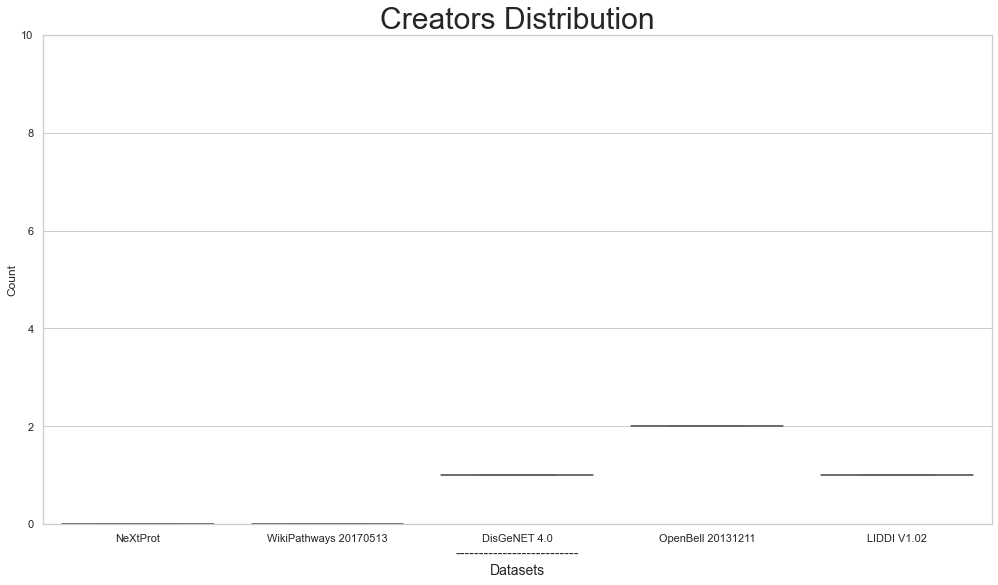

In [379]:
dataCreators = pd.read_csv('distributionCreators.csv')

sns.set(style="whitegrid")
ax = sns.boxplot(x="DataSets", y="Count", data=dataCreators, palette="Set3")
ax.axes.set_title("Creators Distribution",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
ax.set_ylim(0, 10);

## Rights Distribution in all datasets

In [8]:
#Getting All creators from DisGetNET
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rights) ?rights .
  }
}GROUP By ?np"""

results = queryDisGeNET(query)
dgRights = get_array(results)
print(dgRights)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?rights (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rights) ?rights .
  }
}GROUP By ?rights"""

results = queryDisGeNET(query)
dgRightsCont = get_array3(results)
print(dgRightsCont)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?licence (count(distinct ?licence) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:licence) ?licence .
  }
}GROUP By ?licence"""

results = queryDisGeNET(query)
dgLicenceCont = get_array4(results)
print(dgLicenceCont)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

[['http://opendatacommons.org/licenses/odbl/1.0/'], [1]]
[[], []]


In [9]:
#Getting All creators from neXtProt
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rights) ?rights .
  }
}GROUP By ?np"""

results = queryNeXtProt(query)
nxtRights = get_array(results)
print(nxtRights)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?rights (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rights) ?rights .
  }
}GROUP By ?rights"""

results = queryNeXtProt(query)
nxtRightsCont = get_array3(results)
print(nxtRightsCont)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?licence (count(distinct ?licence) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:licence) ?licence .
  }
}GROUP By ?licence"""

results = queryNeXtProt(query)
nxtLicenceCont = get_array4(results)
print(nxtLicenceCont)

# neXtProt has no creator 
# Describe Nanopublication
#:NX_Q9UKF6-1_PTM-0207_2.RA-3WCl5c7ZO6xYamZ7X7jL0Ahfe3zQ2bBRH68P66hHUI
#        a                      np:Nanopublication ;
#        dcterms:created        "2014-09-19T00:00:00Z"^^xsd:dateTime ;
#        dcterms:rights         <http://creativecommons.org/licenses/by/3.0/> ;
#        dcterms:rightsHolder   <http://nextprot.org> ;
#        prv:usedData           "neXtProt database" ;
#        <http://swan.mindinformatics.org/ontologies/1.2/pav/authoredBy>
#          "CALIPHO project" ;
#        <http://swan.mindinformatics.org/ontologies/1.2/pav/authoredBy>
#        <http://orcid.org/0000-0001-6710-1373> , <http://orcid.org/0000-0002-1303-2189> , <http://orcid.org/0000-0003-1813-6857> , <http://orcid.org/0000-0001-6818-334X> ;
#        <http://swan.mindinformatics.org/ontologies/1.2/pav/versionNumber>
#        "1" ;
#      np:hasAssertion        <http://www.nextprot.org/nanopubs#NX_Q9UKF6-1_PTM-0207_2.RA-3WCl5c7ZO6xYamZ7X7jL0Ahfe3zQ2bBRH68P66hHUI#assertion> ;
#      np:hasProvenance       <http://www.nextprot.org/nanopubs#NX_Q9UKF6-1_PTM-0207_2.RA-3WCl5c7ZO6xYamZ7X7jL0Ahfe3zQ2bBRH68P66hHUI#provenance> ;
#      np:hasPublicationInfo  <http://www.nextprot.org/nanopubs#NX_Q9UKF6-1_PTM-0207_2.RA-3WCl5c7ZO6xYamZ7X7jL0Ahfe3zQ2bBRH68P66hHUI#pubinfo> ;
#      prov:wasGeneratedBy    <http://www.nextprot.org/nanopubs#NX_Q9UKF6-1_PTM-0207_2.RA-3WCl5c7ZO6xYamZ7X7jL0Ahfe3zQ2bBRH68P66hHUI#_5> .

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

[['http://creativecommons.org/licenses/by/3.0/'], [1]]
[[], []]


In [45]:
#Getting All creators from Wikipathways
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rights) ?rights .
  }
}GROUP By ?np"""

results = queryWP(query)
wikiRights = get_array(results)
print(wikiRights)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?rights (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:rights) ?rights .
  }
}GROUP By ?rights"""

results = queryWP(query)
wikiRightsCont = get_array3(results)
print(wikiRightsCont)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?licence (count(distinct ?licence) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:licence) ?licence .
  }
}GROUP By ?licence"""

results = queryWP(query)
wikiLicenceCont = get_array4(results)
print(wikiLicenceCont)

#Describe nanopublication
#<http://purl.org/np/RASqUFyaiZdd8viHLNjoTtdv3SvoTJ-Qpx4DpfcXPHQSg>
#        a                      np:Nanopublication ;
#        dcterms:created        "2017-05-08T15:57:43.151+02:00"^^xsd:dateTime ;
#        dcterms:rights         <https://creativecommons.org/licenses/by/3.0/> ;
#        np:hasAssertion        <http://purl.org/np/RASqUFyaiZdd8viHLNjoTtdv3SvoTJ-Qpx4DpfcXPHQSg#assertion> ;
#        np:hasProvenance       <http://purl.org/np/RASqUFyaiZdd8viHLNjoTtdv3SvoTJ-Qpx4DpfcXPHQSg#provenance> ;
#        np:hasPublicationInfo  <http://purl.org/np/RASqUFyaiZdd8viHLNjoTtdv3SvoTJ-Qpx4DpfcXPHQSg#publicationInfo> ;
#        prov:wasDerivedFrom    <http://identifiers.org/wikipathways/WP176_r85063> .

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

[['http://creativecommons.org/publicdomain/zero/1.0/'], [1]]
[[], []]


In [48]:
#Getting All creators from large and small corpus
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>

select (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasProvenance ?provenance .
  }
  graph ?provenance {
    <http://resource.belframework.org/belframework/1.0/knowledge/large_corpus.bel> (dct:rights|dce:rights) ?rights .
  }
}GROUP By ?np"""

results = queryOpenBellLarge(query)
belLargeRights = get_array(results)
print(belLargeRights)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>

select (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasProvenance ?provenance .
  }
  graph ?provenance {
    <http://resource.belframework.org/belframework/1.0/knowledge/large_corpus.bel> (dct:rights|dce:rights) ?rights .
  }
}GROUP By ?np"""

#results = queryOpenBellSmall(query)
#belSmallCreators = get_array(results)


openBellRights = []
openBellRights.extend(belLargeRights)
#openBellCreators.extend(belSmallCreators)
openBellRights.sort()

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>

select ?rights (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasProvenance ?provenance .
  }
  graph ?provenance {
    <http://resource.belframework.org/belframework/1.0/knowledge/large_corpus.bel> (dct:rights|dce:rights) ?rights .
  }
}GROUP By ?rights"""

results = queryOpenBellLarge(query)
openBellRightsCont = get_array3(results)
print(openBellRightsCont)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>

select ?licence (count(distinct ?licence) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (dct:licence) ?licence .
  }
}GROUP By ?licence"""

results = queryOpenBellLarge(query)
openBellLicenceCont = get_array4(results)
print(openBellLicenceCont)

#Describe Nanopublication

#<http://www.tkuhn.ch/bel2nanopub/RAlKFUbz4ZPgXiJNsebuH06skrZbx0Ix7XSWK5z4u69v4>
#        a                      np:Nanopublication ;
#        dct:created            "2014-07-03T14:31:25.409+02:00"^^xsd:dateTime ;
#        pav:createdBy          orcid:0000-0002-1267-0234 , orcid:0000-0001-6818-334X ;
#        np:hasAssertion        <http://www.tkuhn.ch/bel2nanopub/RAlKFUbz4ZPgXiJNsebuH06skrZbx0Ix7XSWK5z4u69v4#assertion> ;
#        np:hasProvenance       <http://www.tkuhn.ch/bel2nanopub/RAlKFUbz4ZPgXiJNsebuH06skrZbx0Ix7XSWK5z4u69v4#provenance> ;
#        np:hasPublicationInfo  <http://www.tkuhn.ch/bel2nanopub/RAlKFUbz4ZPgXiJNsebuH06skrZbx0Ix7XSWK5z4u69v4#pubinfo> .

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

[['Copyright (c) 2011-2012, Selventa. All rights reserved.'], [1]]
[[], []]


In [59]:
#Getting All creators from LIDDI
query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix prov: <http://www.w3.org/ns/prov#>

select (count(distinct ?creator) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
    ?np (prov:wasAttributedTo) ?creator .
  }
}GROUP By ?np"""

results = queryLIDDI(query)
liddiRights = get_array(results)
print(liddiRights)

query = """
prefix np: <http://www.nanopub.org/nschema#>
prefix dct: <http://purl.org/dc/terms/>
prefix dce: <http://purl.org/dc/elements/1.1/>

select ?rights (count(distinct ?rights) as ?count) where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasProvenance ?provenance .
  }
  graph ?provenance {
    <http://resource.belframework.org/belframework/1.0/knowledge/large_corpus.bel> (dct:rights|dce:rights) ?rights .
  }
}GROUP By ?rights"""

results = queryLIDDI(query)
liddiRightsCont = get_array3(results)
print(liddiRightsCont)

query = """
PREFIX np: <http://www.nanopub.org/nschema#>
PREFIX dcterms: <http://purl.org/dc/terms/>
select ?licence (count(distinct ?licence) as ?count)
where {
  graph ?h {
    ?np a np:Nanopublication .
    ?np np:hasPublicationInfo ?pubinfo .
  }
  graph ?pubinfo {
        ?np dcterms:license ?licence .
  }
}
GROUP BY ?licence"""

results = queryLIDDI(query)
liddiLicenceCont = get_array4(results)
print(liddiLicenceCont)

#Describe Nanopublication
#ddir:EID0002_nanopub  a        np:Nanopublication ;
#        dcterms:license        <http://creativecommons.org/licenses/by/3.0/> ;
#        np:hasAssertion        ddir:EID0002_nanopubassertion ;
#        np:hasProvenance       ddir:EID0002_nanopubprovenance ;
#        np:hasPublicationInfo  ddir:EID0002_nanopubpublicationInfo ;
#        prov:generatedAtTime   "2016-04-06T15:01:38.194767"^^xsd:dateTime ;
#        prov:wasAttributedTo   orcid:0000-0001-8499-824X .

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

[[], []]
[['http://creativecommons.org/licenses/by/3.0/'], [1]]


In [61]:
# All Data in the csv File
with open('distributionRights.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Count']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Count'])
    
    # For NeXtProt DataSet
    if (len(nxtRights) > 0):
        for t in nxtRights:
            writer.writerow(['NeXtProt', t])
    else:
        writer.writerow(['NeXtProt', 0])
        
    #For Wikipathways dataset
    if (len(wikiRights) > 0):
        for t in wikiRights:
            writer.writerow(['WikiPathways 20170513', t])
    else:
        writer.writerow(['WikiPathways 20170513', 0])   
        
    #For DisGeNet Dataset
    for t in dgRights:
        writer.writerow(['DisGeNET 4.0', t])
        
    #For OpenBell Dataset
    for t in openBellRights:
        writer.writerow(['OpenBell 20131211', t])

    #For LIDDI Dataset
    for t in liddiRights:
        writer.writerow(['LIDDI V1.02', t])

## Total Nanopublications in each dataset

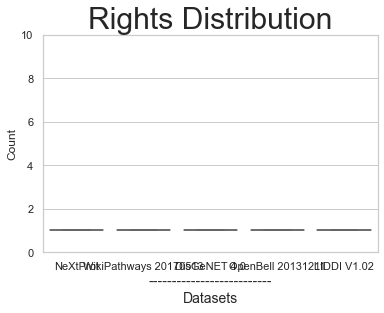

In [62]:
dataRights = pd.read_csv('distributionRights.csv')

sns.set(style="whitegrid")
ax = sns.boxplot(x="DataSets", y="Count", data=dataRights, palette="Set3")
ax.axes.set_title("Rights Distribution",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
ax.set_ylim(0, 10);

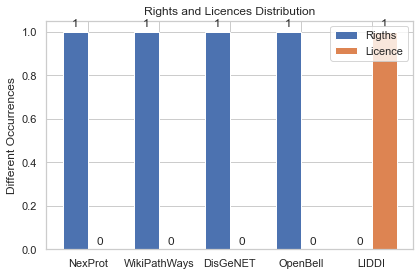

In [80]:
#fig, ax = plt.subplots()
#ax.pie(dgRightsCont[1], labels=dgRightsCont[0], autopct='%1.2f%%')
#ax.axis('equal') # mantenha um circulo
#fig.suptitle("Distribuição dos Direitos Autorais das Nanopublicações do Dataset");

#plt.bar(nxtRightsCont[1][0], dgRightsCont[1])

labels = ['NexProt', 'WikiPathWays', 'DisGeNET', 'OpenBell', 'LIDDI']  # Eixo X
#labels = ['NexProt', 'DisGeNET']  # Eixo X

#print(nxtRightsCont[1])
#print(dgRightsCont[1])
#print(nxtLicenceCont[1])
#print(dgLicenceCont[1])

#for my_elem in nxtRightsCont[1]:
#    print('teste')

s = [str(i) for i in nxtRightsCont[1]] # Converting integers into strings
nxtRightsContNum = str("".join(s)) # Join the string values into one string
nxtRightsContNum= nxtRightsContNum.strip() or '0'
s = [str(i) for i in wikiRightsCont[1]] # Converting integers into strings
wikiRightsContNum = str("".join(s)) # Join the string values into one string
wikiRightsContNum= wikiRightsContNum.strip() or '0'
s = [str(i) for i in dgRightsCont[1]] # Converting integers into strings
dgRightsContNum = str("".join(s)) # Join the string values into one string
dgRightsContNum= dgRightsContNum.strip() or '0'
s = [str(i) for i in openBellRightsCont[1]] # Converting integers into strings
openBellRightsContNum = str("".join(s)) # Join the string values into one string
openBellRightsContNum= openBellRightsContNum.strip() or '0'
s = [str(i) for i in liddiRightsCont[1]] # Converting integers into strings
liddiRightsContNum = str("".join(s)) # Join the string values into one string
liddiRightsContNum= liddiRightsContNum.strip() or '0'

s = [str(i) for i in nxtLicenceCont[1]] # Converting integers into strings
nxtLicenceContNum = str("".join(s)) # Join the string values into one string
nxtLicenceContNum= nxtLicenceContNum.strip() or '0'
s = [str(i) for i in wikiLicenceCont[1]] # Converting integers into strings
wikiLicenceContNum = str("".join(s)) # Join the string values into one string
wikiLicenceContNum= wikiLicenceContNum.strip() or '0'
s = [str(i) for i in dgLicenceCont[1]] # Converting integers into strings
dgLicenceContNum = str("".join(s)) # Join the string values into one string
dgLicenceContNum= dgLicenceContNum.strip() or '0'
s = [str(i) for i in openBellLicenceCont[1]] # Converting integers into strings
openBellLicenceContNum = str("".join(s)) # Join the string values into one string
openBellLicenceContNum= openBellLicenceContNum.strip() or '0'
s = [str(i) for i in liddiLicenceCont[1]] # Converting integers into strings
liddiLicenceContNum = str("".join(s)) # Join the string values into one string
liddiLicenceContNum= liddiLicenceContNum.strip() or '0'

#rights_means = [nxtRightsCont[1], dgRightsCont[1]]
#rights_means = [int(nxtRightsContNum), int(dgRightsContNum)]
rights_means = [int(nxtRightsContNum), int(wikiRightsContNum), int(dgRightsContNum), int(openBellRightsContNum),int(liddiRightsContNum)]
#rights_means = [1,1]
#licence_means = [int(nxtLicenceContNum.replace("", "0")), int(dgLicenceContNum.replace("", "0"))]
licence_means = [int(nxtLicenceContNum), int(wikiLicenceContNum), int(dgLicenceContNum), int(openBellLicenceContNum), int(liddiLicenceContNum)]
#licence_means = [0,0]
#rights_means = [20, 34, 30, 35, 27]
#licence_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rights_means, width, label='Rigths')
rects2 = ax.bar(x + width/2, licence_means, width, label='Licence')

ax.set_ylabel('Different Occurrences')
ax.set_title('Rights and Licences Distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#bar_labels1 = ['ODBL 1.0', 'CC BY 3.0']  # Eixo X
#bar_labels2 = ['', '']  # Eixo X

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [76]:
# The following query represent the count of nanopublication in neXtProt 
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication .
       }
    }
"""

results = queryNeXtProt(query)
nxtTotalNano = get_array(results)

In [381]:
nxtTotalNano

[68746]

In [383]:
# The following query represent the count of nanopublication in DisGeNET 
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication .
       }
    }
"""

results = queryDisGeNET(query)
dgTotalNano = get_array(results)

In [384]:
dgTotalNano

[8235]

In [385]:
# The following query represent the count of nanopublication in Wikipathways 
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication .
       }
    }
"""

results = queryWP(query)
wikiTotalNano = get_array(results)

In [386]:
wikiTotalNano

[16247]

In [388]:
# The following query represent the count of nanopublication in large and small corpus 
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication .
       }
    }
"""

results = queryOpenBellLarge(query)
largeTotalNano = get_array(results)

query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication .
       }
    }
"""

#results = queryOpenBellSmall(query)
#smallTotalNano = get_array(results)

openBelTotalNano = []
#openBelTotalNano.append(largeTotalNano[0] + smallTotalNano[0])
openBelTotalNano.append(largeTotalNano[0])

In [389]:
openBelTotalNano

[48674]

In [390]:
# The following query represent the count of nanopublication in LIDDI 
query = """
prefix np: <http://www.nanopub.org/nschema#>
select (count(*) as ?count) where {
      graph ?h {
        ?_np_iri a np:Nanopublication .
       }
    }
"""

results = queryLIDDI(query)
liddiTotalNano = get_array(results)

In [391]:
liddiTotalNano

[88087]

In [392]:
# All Data in the csv File
with open('totalNanopublications.csv', mode='w') as csv_file:
    fieldnames = ['DataSets', 'Count']
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['DataSets', 'Count'])
    
    # For NeXtProt DataSet
    for t in nxtTotalNano:
            writer.writerow(['neXtProt 19001_20000', t])
    
    #For Wikipathways dataset
    for t in wikiTotalNano:
        writer.writerow(['WikiPathways 20170513', t])
        
    #For DisGeNet Dataset
    for t in dgTotalNano:
        writer.writerow(['DisGeNET 4.0', t])
        
    #For OpenBell Dataset
    for t in openBelTotalNano:
        writer.writerow(['OpenBell 20131211', t])

    #For LIDDI Dataset
    for t in liddiTotalNano:
        writer.writerow(['LIDDI V1.02', t])

Text(0, 0.5, 'Total Nanopublication Count')

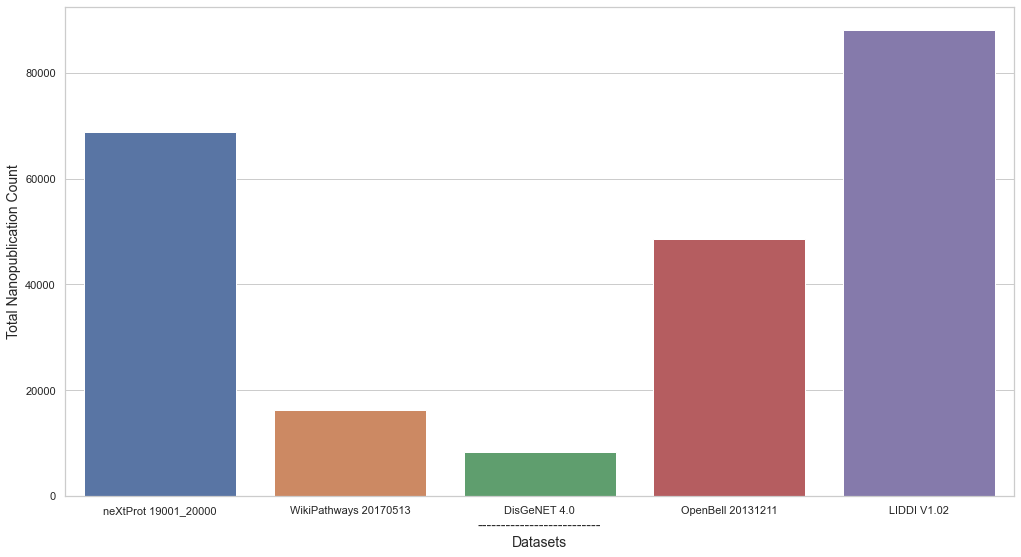

In [393]:
dataNP = pd.read_csv('totalNanopublications.csv')
sns.set(style="whitegrid")
#For bar plot use following line
ax = sns.barplot(x="DataSets", y="Count", data=dataNP)

#For boxplot use following line
#ax = sns.boxplot(x="DataSets", y="Count", data=dataNP, palette="Set3")

#ax.axes.set_title("Total number of Nanopublications in each dataset",fontsize=30)
ax.axes.set_xlabel('--------------------------\nDatasets', fontsize=14)
ax.axes.set_ylabel('Total Nanopublication Count', fontsize=14)